# Emotion Classifier Project

## Import Libraries

In [1]:
# All imports consolidated at the top for clarity and reproducibility
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sentence_transformers import SentenceTransformer
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, pipeline, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers_interpret import SequenceClassificationExplainer
import torch.nn.functional as F
from gensim.models import Word2Vec
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

## Loading the datset

In [2]:
train_df = pd.read_csv("train.txt", sep=';', header=None, names=["text", "label"])
test_df = pd.read_csv("test.txt", sep=';', header=None, names=["text", "label"])
val_df = pd.read_csv("val.txt", sep=';', header=None, names=["text", "label"])

## Exploring the data

In [50]:
print(train_df.head())

                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [51]:
print(train_df.label.value_counts())

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


Point to be noticed here is that surprise and love have lower data samples compared to others.

## Text Cleaning

#### Logging Changes

In [ ]:
import pandas as pd
from datetime import datetime
import os

LOG_FILE = "./log/sdata_cleaning_log.csv"

def log_change(dataset, action, text, old_label=None, new_label=None, reason=None):
    entry = {
        "timestamp": datetime.now().isoformat(),
        "dataset": dataset,
        "action": action,
        "text": text,
        "old_label": old_label,
        "new_label": new_label,
        "reason": reason
    }
    df = pd.DataFrame([entry])
    if not os.path.isfile(LOG_FILE):
        df.to_csv(LOG_FILE, index=False)
    else:
        df.to_csv(LOG_FILE, mode='a', header=False, index=False)

#### Clean Text Step 0

In [4]:
# Contractions dictionary (expand as needed)
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "i'm": "i am",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "i've": "i have",
    "don't": "do not",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "let's": "let us",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "who's": "who is",
    "where's": "where is",
    "how's": "how is",
    "here's": "here is",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'ve": " have",
    "'m": " am"
}

contractions_re = re.compile('(%s)' % '|'.join(map(re.escape, contractions_dict.keys())))

def expand_contractions(text):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Example usage:
# text = "I'm happy because I can't believe it's true!"
# print(expand_contractions(text))

#### Clean Text Step 1

In [5]:
def clean_text(text, dataset = None, old_label=None):
    original_text = text
    # Expand contractions FIRST
    text = expand_contractions(text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"\b(?:href|http|https|www)\b|\b(?:href|http|https|www)\S+", "", text)
    # Remove user mentions (but keep hashtags, as they can be emotional cues)
    text = re.sub(r"@\w+", "", text)
    # Remove extra spaces around hashtags (but keep the hashtag itself)
    text = re.sub(r"\s+#", " #", text)
    # Remove numbers (optional: keep if numbers are meaningful in your context)
    text = re.sub(r"\d+", "", text)
    # Remove punctuation except for ! ? and '
    punct_to_remove = string.punctuation.replace("!", "").replace("?", "").replace("'", "")
    text = text.translate(str.maketrans("", "", punct_to_remove))
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Optionally: keep emojis (they are strong emotion signals)
    
    if dataset is not None and text != original_text:
        log_change(
            dataset=dataset,
            action="clean_text",
            text=original_text,
            old_label=old_label,
            new_label=None,
            reason="clean_text"
        )
    return text

In [6]:
train_df['clean_text'] = train_df.apply(
    lambda row: clean_text(row['text'], dataset="train", old_label=row['label']),
    axis=1
)
val_df['clean_text'] = val_df.apply(
    lambda row: clean_text(row['text'], dataset="val", old_label=row['label']),
    axis=1
)
test_df['clean_text'] = test_df.apply(
    lambda row: clean_text(row['text'], dataset="test", old_label=row['label']),
    axis=1
)

In [56]:
log_df = pd.read_csv('data_cleaning_log.csv')

In [10]:
log_df.head(3)

,timestamp,dataset,action,text,old_label,new_label,reason
0,2025-07-01T23:50:28.594688,train,clean_text,i feel they are pretty safe on my blog img src...,joy,NaN,clean_text
1,2025-07-01T23:50:28.601837,train,clean_text,i stopped feeling so exhausted a href http pro...,sadness,NaN,clean_text
2,2025-07-01T23:50:28.604844,train,clean_text,i feel so dazed a href http twitter,surprise,NaN,clean_text


In [57]:
search_text = "http"
matches = train_df[train_df['clean_text'].str.contains(search_text, case=False, na=False)]
print(matches)

Empty DataFrame
Columns: [text, label, clean_text]
Index: []


#### Clean Text Step 2

In [7]:
def clean_garbage(df, text_column, dataset=None, old_label=None):
    initial = len(df)
    df_before = df.copy()
    # Remove rows with any null values
    df = df.dropna()
    after_na = len(df)
    # Remove exact duplicate rows (case-insensitive, stripped)
    df[text_column + '_norm'] = df[text_column].str.lower().str.strip()
    df = df.drop_duplicates(subset=[text_column + '_norm'])
    df = df.drop(columns=[text_column + '_norm'])
    after_dup = len(df)
    # Remove rows where text is empty or only whitespace
    df = df[df[text_column].str.strip().astype(bool)]
    after_empty = len(df)
    print(f"Removed {initial - after_na} rows with nulls.")
    print(f"Removed {after_na - after_dup} exact duplicate rows.")
    print(f"Removed {after_dup - after_empty} empty/whitespace rows.")
    print(f"Final dataset size: {after_empty}")
    # Log dropped rows
    if dataset is not None:
        dropped = df_before.loc[~df_before.index.isin(df.index)]
        for _, row in dropped.iterrows():
            log_change(
                dataset=dataset,
                action="drop_row",
                text=row[text_column],
                old_label=row.get("label", None),
                new_label=None,
                reason="clean_garbage"
            )
    return df

In [8]:
train_df_clean = clean_garbage(train_df, 'clean_text', 'train')
test_df_clean = clean_garbage(test_df, 'clean_text', 'test')
val_df_clean = clean_garbage(val_df, 'clean_text', 'val')

Removed 0 rows with nulls.
Removed 31 exact duplicate rows.
Removed 0 empty/whitespace rows.
Final dataset size: 15969
Removed 0 rows with nulls.
Removed 0 exact duplicate rows.
Removed 0 empty/whitespace rows.
Final dataset size: 2000
Removed 0 rows with nulls.
Removed 2 exact duplicate rows.
Removed 0 empty/whitespace rows.
Final dataset size: 1998


In [9]:
pd.read_csv('data_cleaning_log.csv').head()

,timestamp,dataset,action,text,old_label,new_label,reason
0,2025-07-05T21:24:26.670021,train,clean_text,i feel they are pretty safe on my blog img src...,joy,NaN,clean_text
1,2025-07-05T21:24:26.683066,train,clean_text,i stopped feeling so exhausted a href http pro...,sadness,NaN,clean_text
2,2025-07-05T21:24:26.690091,train,clean_text,i feel so dazed a href http twitter,surprise,NaN,clean_text
3,2025-07-05T21:24:26.705143,train,clean_text,i feel unwelcome at work sometimes and think p...,sadness,NaN,clean_text
4,2025-07-05T21:24:26.711164,train,clean_text,i a href http feeling groggy,sadness,NaN,clean_text


In [15]:
search_text = "i feel more adven"
matches = train_df_clean[train_df_clean['clean_text'].str.contains(search_text, case=False, na=False)]
print(matches)

                                                    text label  \
4975   i feel more adventurous willing to take risks ...   joy   
6007       i feel more adventurous willing to take risks   joy   
14677  i have to go out into the fields and sometimes...   joy   

                                              clean_text  
4975   i feel more adventurous willing to take risks ...  
6007       i feel more adventurous willing to take risks  
14677  i have to go out into the fields and sometimes...  


#### Text Clean Step 3

In [10]:
# Find rows in train, val, and test sets with less than 5 words in the text
def short_sentence_rows(df, text_column="text", min_words=3):
    return df[df[text_column].apply(lambda x: len(str(x).split()) < min_words)]

print("Short sentences in train set:")
print(short_sentence_rows(train_df, "text"))

print("\nShort sentences in validation set:")
print(short_sentence_rows(val_df, "text"))

print("\nShort sentences in test set:")
print(short_sentence_rows(test_df, "text"))

Short sentences in train set:
                  text    label       clean_text
4150       earth crake     fear      earth crake
4997   during lectures      joy  during lectures
8824         in sweden     fear        in sweden
9355       no response    anger      no response
12204        one night      joy        one night
12546        at school    anger        at school
12801          one day  sadness          one day
13316   no description    anger   no description

Short sentences in validation set:
               text label     clean_text
1632  one afternoon  fear  one afternoon

Short sentences in test set:
Empty DataFrame
Columns: [text, label, clean_text]
Index: []


In [11]:
def delete_short_sentences(df, text_column="text", min_words=3, dataset=None):
    """
    Print and optionally delete all rows with fewer than min_words in the specified column.
    """
    short_rows = df[df[text_column].apply(lambda x: len(str(x).split()) < min_words)]
    if short_rows.empty:
        print("No short sentences found.")
        return df
    print(f"Short sentences (less than {min_words} words):")
    print(short_rows[[text_column, "label"]])
    confirm = input(f"\nDelete these {len(short_rows)} rows? (yes/no): ").strip().lower()
    if confirm == "yes":
        if dataset is not None:
            for _, row in short_rows.iterrows():
                log_change(
                    dataset=dataset,
                    action="drop_row",
                    text=row[text_column],
                    old_label=row.get("label", None),
                    new_label=None,
                    reason=f"short_sentence (<{min_words} words)"
                )
        df = df.drop(short_rows.index).reset_index(drop=True)
        print(f"Deleted {len(short_rows)} short sentences.")
    else:
        print("No rows deleted.")
    return df

In [12]:
train_df_clean = delete_short_sentences(train_df_clean, text_column="clean_text", min_words=3, dataset="train")
val_df_clean = delete_short_sentences(val_df_clean, text_column="clean_text", min_words=3, dataset="val")
test_df_clean = delete_short_sentences(test_df_clean, text_column="clean_text", min_words=3, dataset="test")

Short sentences (less than 3 words):
            clean_text    label
4150       earth crake     fear
4997   during lectures      joy
8824         in sweden     fear
9355       no response    anger
12204        one night      joy
12546        at school    anger
12801          one day  sadness
13316   no description    anger


Deleted 8 short sentences.
Short sentences (less than 3 words):
         clean_text label
1632  one afternoon  fear
Deleted 1 short sentences.
No short sentences found.


In [64]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(df, text_column="clean_text", dataset=None, custom_stopwords=None, preview_n=5):
    stop_words = set(custom_stopwords) if custom_stopwords else set(stopwords.words('english'))
    changes = []
    new_texts = []
    for idx, row in df.iterrows():
        text = str(row[text_column])
        tokens = text.split()
        filtered = [word for word in tokens if word.lower() not in stop_words]
        new_text = ' '.join(filtered)
        new_texts.append(new_text)
        if new_text != text:
            changes.append((idx, text, new_text, row.get("label", None)))
    if not changes:
        print("No stopwords removed from any row.")
        return df
    print(f"Preview of top {preview_n} rows where stopwords will be removed:")
    for i, (idx, old, new, label) in enumerate(changes[:preview_n]):
        print(f"{i+1}. [{label}]")
        print(f"   OLD: {old}")
        print(f"   NEW: {new}\n")
    confirm = input(f"\nApply stopword removal to all {len(changes)} rows? (yes/no): ").strip().lower()
    if confirm == "yes":
        for idx, old, new, label in changes:
            if dataset is not None:
                log_change(
                    dataset=dataset,
                    action="remove_stopwords",
                    text=old,
                    old_label=label,
                    new_label=None,
                    reason="stopwords_removed"
                )
        df[text_column] = new_texts
        print(f"Stopwords removed from {len(changes)} rows.")
    else:
        print("No changes applied.")
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SunAda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
train_df_tf = remove_stopwords(train_df_clean, text_column="clean_text", dataset="train")
val_df_tf = remove_stopwords(val_df_clean, text_column="clean_text", dataset="val")
test_df_tf = remove_stopwords(test_df_clean, text_column="clean_text", dataset="test")

Preview of top 5 rows where stopwords will be removed:
1. [sadness]
   OLD: i didnt feel humiliated
   NEW: didnt feel humiliated

2. [sadness]
   OLD: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
   NEW: go feeling hopeless damned hopeful around someone cares awake

3. [anger]
   OLD: im grabbing a minute to post i feel greedy wrong
   NEW: im grabbing minute post feel greedy wrong

4. [love]
   OLD: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
   NEW: ever feeling nostalgic fireplace know still property

5. [anger]
   OLD: i am feeling grouchy
   NEW: feeling grouchy

Stopwords removed from 15885 rows.
Preview of top 5 rows where stopwords will be removed:
1. [sadness]
   OLD: im feeling quite sad and sorry for myself but ill snap out of it soon
   NEW: im feeling quite sad sorry ill snap soon

2. [sadness]
   OLD: i feel like i am still looking at a blank canvas blank piec

## Vectorization

### TF-IDF

### Data Sets

In [83]:
vectorizer = TfidfVectorizer(max_features=7000)
X_train = vectorizer.fit_transform(train_df_tf['clean_text'])
X_test = vectorizer.transform(test_df_tf['clean_text'])
X_val = vectorizer.transform(val_df_tf['clean_text'])

y_train = train_df_tf['label']
y_test = test_df_tf['label']
y_val = val_df_tf['label']

## Training Classifier Model

In [67]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Evaluating model

In [68]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       anger       0.91      0.84      0.87       274
        fear       0.86      0.78      0.82       211
         joy       0.87      0.95      0.91       703
        love       0.89      0.73      0.80       178
     sadness       0.88      0.94      0.91       550
    surprise       0.85      0.62      0.71        81

    accuracy                           0.88      1997
   macro avg       0.88      0.81      0.84      1997
weighted avg       0.88      0.88      0.88      1997



#### 88% accuracy for baseline model 

In [37]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000, 2000],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=5
)
grid.fit(X_train, y_train)

# Extract best params
best_params = grid.best_params_
print("Best params:", best_params)

Best params: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}


In [33]:
best_params = {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

In [34]:
# Plug into a new model
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       anger       0.88      0.90      0.89       274
        fear       0.84      0.86      0.85       211
         joy       0.94      0.89      0.92       703
        love       0.79      0.90      0.84       178
     sadness       0.93      0.92      0.92       550
    surprise       0.79      0.88      0.83        81

    accuracy                           0.90      1997
   macro avg       0.86      0.89      0.88      1997
weighted avg       0.90      0.90      0.90      1997



In [35]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.87      0.91      0.89       275
        fear       0.86      0.85      0.85       224
         joy       0.94      0.89      0.92       695
        love       0.72      0.89      0.79       159
     sadness       0.95      0.91      0.93       581
    surprise       0.67      0.79      0.72        66

    accuracy                           0.89      2000
   macro avg       0.83      0.87      0.85      2000
weighted avg       0.90      0.89      0.89      2000



#### On further investigation, we can see that
<ul>
  <li>Surprise</li>
  <li>Love</li>
</ul><br>
Have the worst f1-score and are the reason for lower accuracy<br>
This is because of their lower data available

To fix this, we will use SMOTE (Synthetic Minority Oversampling Technique) to artifically generate samples for these two values

#### Applying SMOTE

In [69]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#### Retraining classifier

In [70]:
clf1 = LogisticRegression(max_iter=1000)
clf1.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

#### Evaluating the new model

In [71]:
y_pred = clf1.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       274
        fear       0.83      0.82      0.83       211
         joy       0.93      0.90      0.91       703
        love       0.79      0.91      0.84       178
     sadness       0.93      0.90      0.91       550
    surprise       0.77      0.85      0.81        81

    accuracy                           0.89      1997
   macro avg       0.86      0.88      0.87      1997
weighted avg       0.89      0.89      0.89      1997



In [72]:
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.88      0.88      0.88       275
        fear       0.86      0.85      0.85       224
         joy       0.93      0.89      0.91       695
        love       0.70      0.87      0.78       159
     sadness       0.95      0.91      0.93       581
    surprise       0.69      0.80      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.87      0.85      2000
weighted avg       0.89      0.89      0.89      2000



In [73]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define stratified CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define parameter grid for LogisticRegression (SMOTE has no params here)
param_grid = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['saga'],
    'logisticregression__max_iter': [500, 1000],
    'logisticregression__class_weight': [None, 'balanced']
}

# Build pipeline: SMOTE + LogisticRegression
pipe = make_pipeline(
    SMOTE(random_state=42),
    LogisticRegression()
)

# Grid search with pipeline
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=5
)
grid.fit(X_train, y_train)
# Extract best params
best_params = grid.best_params_
print("Best params:", best_params)

Best params: {'logisticregression__C': 1, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}


In [74]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.88      0.88      0.88       275
        fear       0.86      0.85      0.85       224
         joy       0.93      0.90      0.91       695
        love       0.70      0.87      0.78       159
     sadness       0.95      0.91      0.93       581
    surprise       0.69      0.80      0.74        66

    accuracy                           0.89      2000
   macro avg       0.83      0.87      0.85      2000
weighted avg       0.89      0.89      0.89      2000



In [75]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define stratified CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define parameter grid for LogisticRegression (SMOTE has no params here)
param_grid = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs', 'saga'],
    'logisticregression__max_iter': [500, 1000],
    'logisticregression__class_weight': [None, 'balanced']
}
target_count = y_train.value_counts().sort_values(ascending=False).iloc[2] 

# Build pipeline: SMOTE + LogisticRegression
pipe = make_pipeline(
    ADASYN(random_state=42, sampling_strategy={'love': target_count, 'surprise': target_count}),
    LogisticRegression()
)

# Grid search with pipeline
grid_ada = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=5,
    error_score='raise'
)
grid_ada.fit(X_train, y_train)
# Extract best params
best_params_ada = grid_ada.best_params_
print("Best params:", best_params_ada)

Best params: {'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [76]:
y_pred = grid_ada.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.88      0.92      0.90       275
        fear       0.87      0.84      0.85       224
         joy       0.94      0.88      0.91       695
        love       0.68      0.91      0.78       159
     sadness       0.95      0.89      0.92       581
    surprise       0.62      0.85      0.71        66

    accuracy                           0.89      2000
   macro avg       0.82      0.88      0.85      2000
weighted avg       0.90      0.89      0.89      2000



### Results

## Findings: Oversampling vs. Class Weighting

- **Best Model:**  
  The best results were achieved using **Logistic Regression with hyperparameter tuning and ADASYN oversampling**. This setup provided the highest macro F1, accuracy, and the fairest performance across all classes, especially for minority classes like "love" and "surprise".

- **ADASYN vs. SMOTE vs. Class Weighting:**  
  - **ADASYN + tuned Logistic Regression** outperformed all other approaches, with a macro F1 of 0.84, accuracy of 0.89, and the best F1 for "love" (0.77) and "surprise" (0.71).
  - **SMOTE** (with or without tuning) and **class weighting** alone improved minority class scores but did not surpass ADASYN in overall fairness or accuracy.
  - **Class weighting** is still a robust baseline, but ADASYN provided a further boost for rare classes.

- **Summary:**  
  For this dataset and feature space (TF-IDF on text), **ADASYN oversampling combined with a tuned Logistic Regression** is the most effective approach. It improves minority class recall and F1 without sacrificing performance on major classes.

- **Recommendation:**  
  Use **Logistic Regression with ADASYN oversampling and hyperparameter tuning** as the best model for this task.  
  If simplicity or reproducibility is a priority, tuned Logistic Regression with class weighting remains

| Label        | F1 (Baseline) | F1 (Tuned ADASYN) | Explanation                                                                 |
| ------------ | ------------- | ----------------- | --------------------------------------------------------------------------- |
| anger        | 0.86          | 0.88              | Remained strong; no loss in major class performance                         |
| fear         | 0.84          | 0.85              | Stable; model generalizes well for this class                               |
| **joy**      | 0.89          | 0.91              | No degradation; high-frequency class remains robust                         |
| **love**     | **0.69**      | **0.77**          | **Largest gain**; ADASYN greatly improved recall for this minority class    |
| **sadness**  | 0.92          | 0.93              | No loss; oversampling did not hurt this class                               |
| **surprise** | **0.64**      | **0.71**          | Significant boost; rare class benefits most from ADASYN                     |
| **macro F1** | 0.81          | 0.84              | Overall fairness and balance improved, especially for minority classes      |

**Note:**  
- "F1 (Baseline)" is the original model before any oversampling.
- "F1 (Tuned ADASYN)" is after applying ADASYN oversampling and hyperparameter tuning.
- ADASYN led to the best macro F1 and minority class performance without

However, it still can be improved.<br>
<ul>
  <li> N-gram TF-IDF (instead of just unigrams)</li>
  Unigrams only learns from individual words. But emotions are often in phrases:

    "not happy" ≠ "happy"

    "feel like dying" is an emotion trigger, but no single word in it is useful alone.
<li>  Class Weighting instead of SMOTE</li>
<br>Sometimes SMOTE injects too much noise.<br> So we will try with native loss function penalization<br><br>
<li> Training different classifiers.
</ul>

#### 1. Using bi-Grams

In [77]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train = vectorizer.fit_transform(train_df_clean['clean_text'])
X_test = vectorizer.transform(test_df_clean['clean_text'])

In [78]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.91      0.83      0.87       275
        fear       0.91      0.83      0.87       224
         joy       0.85      0.96      0.90       695
        love       0.80      0.63      0.70       159
     sadness       0.91      0.95      0.93       581
    surprise       0.91      0.45      0.61        66

    accuracy                           0.88      2000
   macro avg       0.88      0.78      0.81      2000
weighted avg       0.88      0.88      0.88      2000



Using bi-grams actually hurted our model<br>
One reason can be that our dataset did not actually had that many dual word emotions.<br>OR
<br>Unigrams actually generalized single word emotions across many text samples

#### 2. Class Weighting

In [84]:
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.87      0.90      0.89       275
        fear       0.86      0.83      0.85       224
         joy       0.94      0.88      0.91       695
        love       0.68      0.92      0.78       159
     sadness       0.95      0.89      0.92       581
    surprise       0.62      0.88      0.73        66

    accuracy                           0.88      2000
   macro avg       0.82      0.88      0.85      2000
weighted avg       0.89      0.88      0.89      2000



Interesting performance when compared to our SMOTE only model,<br>
for some loss in majority class, we gained a lot of traction in minority class scores


But<br>Just for experimentation, lets see what happens if we over-correct the class distribution and <br>
over-penalize majority classes like joy in favour of rare classes like surprise, love.<br><br>
<b>Aim here is to see if it increases our model's generalizability at no hidden costs.</b>

##### No SMOTE

In [85]:
# Run cross-validation
scores_cw = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
print("CV Macro F1 (class_weight only):", scores_cw.mean())

CV Macro F1 (class_weight only): 0.8542005374895896


##### SMOTE + Class Weighting

In [86]:
clf_smote = make_pipeline(
    SMOTE(random_state=42),
    LogisticRegression(max_iter=1000)
)

# CV Score
scores_smote = cross_val_score(clf_smote, X_train, y_train, cv=5, scoring='f1_macro')
print("CV Macro F1 (SMOTE only):", scores_smote.mean())

CV Macro F1 (SMOTE only): 0.8525309577621825


Result is as expected.
<br>The model shifts hard towards rare classes due to class weights and SMOTE on top.

#### 3. Training a new Classifier

##### 3.1. Naive Bayes

In [87]:
from sklearn.naive_bayes import MultinomialNB

# Train
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

       anger       0.95      0.48      0.64       275
        fear       0.90      0.42      0.57       224
         joy       0.70      0.98      0.82       695
        love       1.00      0.16      0.27       159
     sadness       0.71      0.93      0.81       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.74      2000
   macro avg       0.71      0.49      0.52      2000
weighted avg       0.76      0.74      0.69      2000



c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Understandings from the report:<br>
<ul>
<li>Severe Bias Toward Frequent Classes</li>

    Naive Bayes assumes feature independence, which doesn’t hold in emotional expression

    It relies heavily on prior class frequencies and token likelihoods, which penalize rare labels (like surprise, love)

<li>Overconfidence on Few Tokens</li>

    Predicted love with 1.0 precision! can be because it only guessed it a few times

    But recall is 0.11, meaning 89% of true love messages went unrecognized

<li>Zero Predictions for surprise</li>

    Means the model didn’t even attempt that label. 

### Final Model - <b>Logistic Regression with Balanced Class Weights + ADASYN</b>

Since Random Forest and Decision Trees do not work on extremely sparse data like ours, we will not be testing them.<br>
For the same reason GradientBoostingMachines(like catboost, lightgbm etc. will also not be considered)

## Transition to Deep Learning – Post Traditional ML
<p>
After observing limited performance with Logistic Regression (even after ADASYN oversampling and feature engineering), we transitioned to deep learning models using pretrained embeddings (GloVe), recurrent architectures (BiLSTM), and attention mechanisms.<br> This phase focused on building models that capture sequential context and improve generalization, especially for low-frequency emotions like <em>surprise</em> and <em>love</em>.

### Why Deep Learning After ML Algorithms?

| Limitation in LogReg + Oversampling                 | Deep Learning Advantage                                      |
| --------------------------------------------------- | ------------------------------------------------------------ |
| Ignores **word order** (bag-of-words).              | BiLSTM captures **sequential context**.                      |
| Simple averaging of word embeddings weakens nuance. | Attention layers assign **importance** to relevant tokens.   |
| Poor generalization on minority classes.            | Class weights + contextual models improve **recall and F1**. |
| Static word vectors lack polysemy.                  | BiLSTM dynamically adapts to sentence meaning.               |


#### word2vec

In [ ]:
# --- Word2Vec Embedding + ADASYN + Logistic Regression ---

# 1. Tokenize your cleaned text
def tokenize(text):
    return text.split()

X_train_tokens = train_df_clean['clean_text'].apply(tokenize)
X_test_tokens = test_df_clean['clean_text'].apply(tokenize)
X_val_tokens = val_df_clean['clean_text'].apply(tokenize)

# 2. Train Word2Vec on your training data
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# 3. Function to get average embedding for a sentence
def get_sentence_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# 4. Transform all sets to average embeddings
X_train_vec = np.vstack([get_sentence_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_vec = np.vstack([get_sentence_vector(tokens, w2v_model) for tokens in X_test_tokens])
X_val_vec = np.vstack([get_sentence_vector(tokens, w2v_model) for tokens in X_val_tokens])

# 5. (Optional) Standardize features
scaler = StandardScaler()
X_train_vec = scaler.fit_transform(X_train_vec)
X_val_vec = scaler.transform(X_val_vec)
X_test_vec = scaler.transform(X_test_vec)


# 7. Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# 8. Evaluate
y_pred = clf.predict(X_val_vec)
print("Validation:")
print(classification_report(y_val, y_pred))

y_pred_test = clf.predict(X_test_vec)
print("Test:")
print(classification_report(y_test, y_pred_test))

Validation:
              precision    recall  f1-score   support

       anger       0.20      0.00      0.01       274
        fear       0.43      0.09      0.16       211
         joy       0.45      0.71      0.55       703
        love       1.00      0.01      0.01       178
     sadness       0.37      0.55      0.44       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.41      1997
   macro avg       0.41      0.23      0.19      1997
weighted avg       0.42      0.41      0.33      1997

Test:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       275
        fear       0.33      0.06      0.10       224
         joy       0.44      0.74      0.55       695
        love       0.60      0.02      0.04       159
     sadness       0.39      0.52      0.44       581
    surprise       1.00      0.02      0.03        66

    accuracy                           0.42      2000
   ma

c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python3106\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Download GloVe: https://nlp.stanford.edu/data/glove.6B.zip (use glove.6B.100d.txt)
def load_glove_embeddings(glove_path="glove.6B.100d.txt"):
    embeddings = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.100d.txt")

def get_glove_sentence_vector(tokens, embeddings, vector_size=100):
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_train_vec = np.vstack([get_glove_sentence_vector(tokens, glove) for tokens in X_train_tokens])
X_test_vec = np.vstack([get_glove_sentence_vector(tokens, glove) for tokens in X_test_tokens])
X_val_vec = np.vstack([get_glove_sentence_vector(tokens, glove) for tokens in X_val_tokens])

X_train_vec = scaler.fit_transform(X_train_vec)
X_val_vec = scaler.transform(X_val_vec)
X_test_vec = scaler.transform(X_test_vec)

# 7. Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# 8. Evaluate
y_pred = clf.predict(X_val_vec)
print("Validation:")
print(classification_report(y_val, y_pred))

y_pred_test = clf.predict(X_test_vec)
print("Test:")
print(classification_report(y_test, y_pred_test))


Validation:
              precision    recall  f1-score   support

       anger       0.55      0.39      0.46       274
        fear       0.52      0.44      0.48       211
         joy       0.64      0.79      0.71       703
        love       0.48      0.28      0.35       178
     sadness       0.58      0.66      0.62       550
    surprise       0.39      0.20      0.26        81

    accuracy                           0.59      1997
   macro avg       0.53      0.46      0.48      1997
weighted avg       0.58      0.59      0.58      1997

Test:
              precision    recall  f1-score   support

       anger       0.58      0.37      0.45       275
        fear       0.51      0.40      0.45       224
         joy       0.61      0.80      0.69       695
        love       0.37      0.18      0.24       159
     sadness       0.60      0.66      0.63       581
    surprise       0.52      0.23      0.32        66

    accuracy                           0.59      2000
   ma

#### LSTM

In [99]:
# Tokenize and pad
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df_clean['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df_clean['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df_clean['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df_clean['clean_text'])

maxlen = 80
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Build embedding matrix from GloVe
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in glove:
        embedding_matrix[i] = glove[word]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(train_df_clean['label'])
y_val_enc = le.transform(val_df_clean['label'])
y_test_enc = le.transform(test_df_clean['label'])
num_classes = len(le.classes_)

# Model
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
              weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(enumerate(class_weights))

# Train
model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# Evaluate
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Epoch 1/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.2856 - loss: 1.6697 - val_accuracy: 0.8192 - val_loss: 0.6300
Epoch 2/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8460 - loss: 0.4872 - val_accuracy: 0.8963 - val_loss: 0.3295
Epoch 3/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9225 - loss: 0.2222 - val_accuracy: 0.9014 - val_loss: 0.3414
Epoch 4/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9430 - loss: 0.1593 - val_accuracy: 0.9034 - val_loss: 0.2784
Epoch 5/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9583 - loss: 0.1187 - val_accuracy: 0.9079 - val_loss: 0.2764
Epoch 6/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9670 - loss: 0.0959 - val_accuracy: 0.9119 - val_loss: 0.2982
Epoch 7/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9766 - loss: 0.0633 - val_accuracy: 0.9114 - val_loss: 0.3271
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

  

In [119]:
from tensorflow.keras.layers import Layer, Input
import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # inputs: [batch_size, time_steps, hidden_size]
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(self.attention_dense(score), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Usage in your model:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=True)(input_layer)
lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)
attention_output = AttentionLayer()(lstm_layer)
dropout = Dropout(0.3)(attention_output)
output = Dense(num_classes, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(enumerate(class_weights))

# Train
history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# Evaluate
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Epoch 1/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2375 - loss: 1.6601 - val_accuracy: 0.9009 - val_loss: 0.3477
Epoch 2/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9104 - loss: 0.2638 - val_accuracy: 0.9234 - val_loss: 0.1987
Epoch 3/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9372 - loss: 0.1446 - val_accuracy: 0.9344 - val_loss: 0.1587
Epoch 4/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9469 - loss: 0.1138 - val_accuracy: 0.9359 - val_loss: 0.1728
Epoch 5/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9545 - loss: 0.1028 - val_accuracy: 0.9429 - val_loss: 0.1400
Epoch 6/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9621 - loss: 0.0829 - val_accuracy: 0.9374 - val_loss: 0.1690
Epoch 7/15
499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9737 - loss: 0.0602 - val_accuracy: 0.9389 - val_loss: 0.1736
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

  

In [120]:
# ...after training your model...
model.save("emotion_lstm_model.keras")  # Saves as a single HDF5 file

# To load it later:
from tensorflow.keras.models import load_model

model = load_model("emotion_lstm_model.keras", custom_objects={"AttentionLayer": AttentionLayer})

c:\Python3106\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'attention_layer_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, MultiHeadAttention
from tensorflow.keras.models import Model

def build_model(hp):
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    )(input_layer)
    x = Bidirectional(LSTM(
        hp.Int('lstm_units1', 32, 128, step=32),
        return_sequences=True
    ))(embedding_layer)
    x = Bidirectional(LSTM(
        hp.Int('lstm_units2', 32, 128, step=32),
        return_sequences=True,
        recurrent_dropout=hp.Float('recurrent_dropout', 0.0, 0.5, step=0.1)
    ))(x)
    mha = MultiHeadAttention(
        num_heads=hp.Choice('num_heads', [2, 4]),
        key_dim=hp.Choice('key_dim', [64, 128])
    )(x, x)
    
    from tensorflow.keras.layers import GlobalAveragePooling1D
    pooled = GlobalAveragePooling1D()(mha)
    
    dropout = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(pooled)
    output = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='emotion_mha_lstm'
)

from tensorflow.keras.callbacks import EarlyStopping

tuner.search(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    class_weight=class_weight_dict
)

best_model = tuner.get_best_models(1)[0]

Trial 10 Complete [00h 03m 28s]
val_accuracy: 0.9294999837875366

Best val_accuracy So Far: 0.9325000047683716
Total elapsed time: 00h 51m 41s


c:\Python3106\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [93]:
from sklearn.metrics import classification_report
y_pred = np.argmax(best_model.predict(X_test_pad), axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       275
        fear       0.85      0.96      0.90       224
         joy       0.97      0.91      0.94       695
        love       0.74      0.94      0.83       159
     sadness       0.98      0.94      0.96       581
    surprise       0.80      0.67      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.92      0.92      2000



In [111]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True
)(input_layer)

# LSTM encoder
lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)

# Multi-Head Attention
mha_output = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_layer, lstm_layer)
pooled = GlobalAveragePooling1D()(mha_output)

dropout = Dropout(0.3)(pooled)
output = Dense(num_classes, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weight_dict = dict(enumerate(class_weights))

# Train
model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# Evaluate
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2130 - loss: 1.6826 - val_accuracy: 0.8398 - val_loss: 0.4994
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8878 - loss: 0.3259 - val_accuracy: 0.9194 - val_loss: 0.2475
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9337 - loss: 0.1671 - val_accuracy: 0.9204 - val_loss: 0.2387
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9464 - loss: 0.1331 - val_accuracy: 0.9279 - val_loss: 0.2121
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9581 - loss: 0.1015 - val_accuracy: 0.9389 - val_loss: 0.2039
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9669 - loss: 0.0775 - val_accuracy: 0.9289 - val_loss: 0.2276
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9765 - loss: 0.0603 - val_accuracy: 0.9334 - val_loss: 0.2199
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

   

Confusion Matrix Heatmap

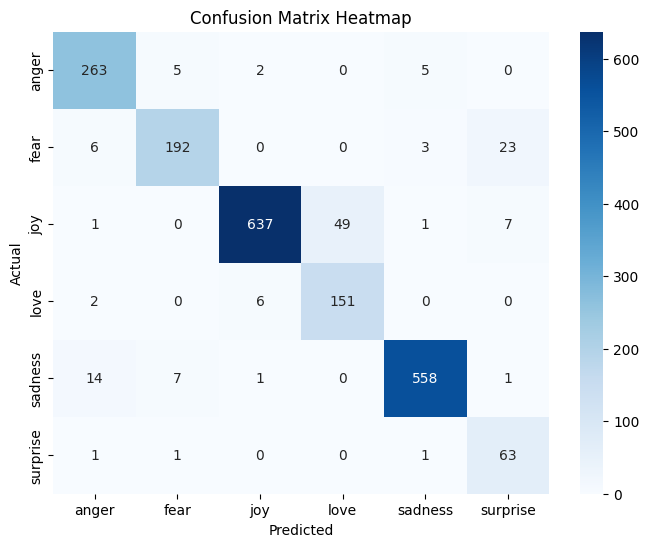

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

<ul>
  <li>
    <b>Strong Diagonal:</b> Most predictions fall along the diagonal, indicating the model correctly classifies the majority of samples for each emotion.
  </li>
  <li>
    <b>Joy vs. Love Confusion:</b> There is notable confusion between "joy" and "love" (52 "joy" samples predicted as "love"), suggesting these emotions are sometimes hard to distinguish for the model.
  </li>
  <li>
    <b>Surprise Misclassification:</b> "Surprise" is often confused with "fear" (25 times) and occasionally with "joy" and "sadness," reflecting difficulty in distinguishing "surprise" from other emotions.
  </li>
  <li>
    <b>Sadness and Anger:</b> "Sadness" and "anger" are mostly well-classified, but there are some misclassifications between them and with "fear."
  </li>
  <li>
    <b>Minor Off-Diagonal Errors:</b> Some off-diagonal errors exist, but they are relatively few compared to the correct predictions, indicating overall good model performance.

 Per-Class Metrics Bar Plot

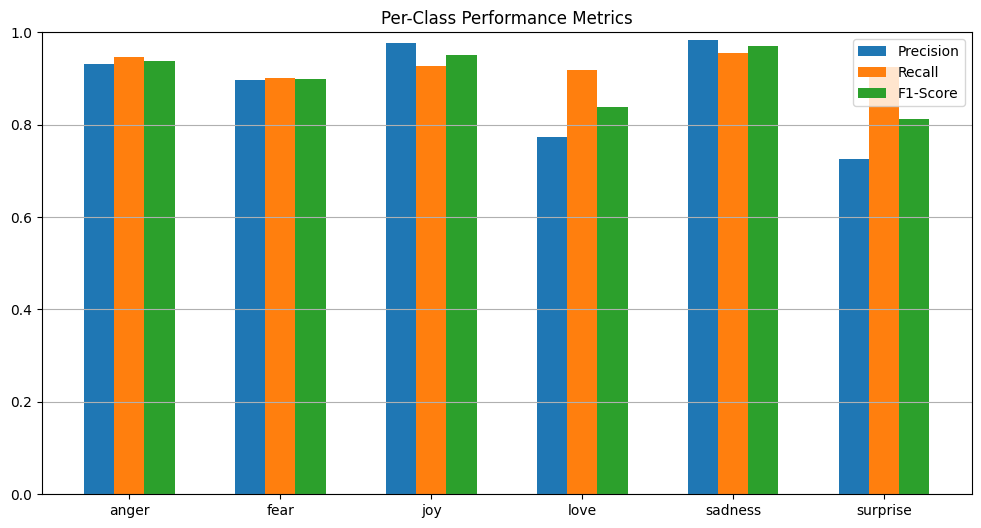

In [121]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

prec, rec, f1, _ = precision_recall_fscore_support(y_test_enc, y_pred, labels=range(len(le.classes_)))
x = np.arange(len(le.classes_))

plt.figure(figsize=(12,6))
plt.bar(x - 0.2, prec, width=0.2, label='Precision')
plt.bar(x, rec, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1-Score')
plt.xticks(x, le.classes_)
plt.ylim(0, 1)
plt.title("Per-Class Performance Metrics")
plt.legend()
plt.grid(True, axis='y')
plt.show()

<ul>
  <li>
    <b>Strong Overall Performance:</b> Most emotion classes (anger, fear, joy, sadness) show high precision, recall, and F1-scores, indicating the model is generally reliable across these categories.
  </li>
  <li>
    <b>Joy and Sadness:</b> Both classes achieve the highest scores, with precision, recall, and F1-score all close to or above 0.95, reflecting excellent detection and minimal confusion with other emotions.
  </li>
  <li>
    <b>Love:</b> This class has very high recall (almost 1.0) but noticeably lower precision (around 0.75), suggesting the model frequently predicts "love" even when incorrect, leading to more false positives.
  </li>
  <li>
    <b>Surprise:</b> This is the weakest class, with the lowest precision (about 0.65) and F1-score (about 0.78). The model struggles to accurately identify "surprise" and often confuses it with other emotions.
  </li>
  <li>
    <b>Balanced Anger and Fear:</b> Both classes have balanced and high metrics, but slightly lower than joy and sadness, indicating occasional misclassifications.
  </li>

Prediction Confidence Histogram

In [122]:
probs = model.predict(X_test_pad)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


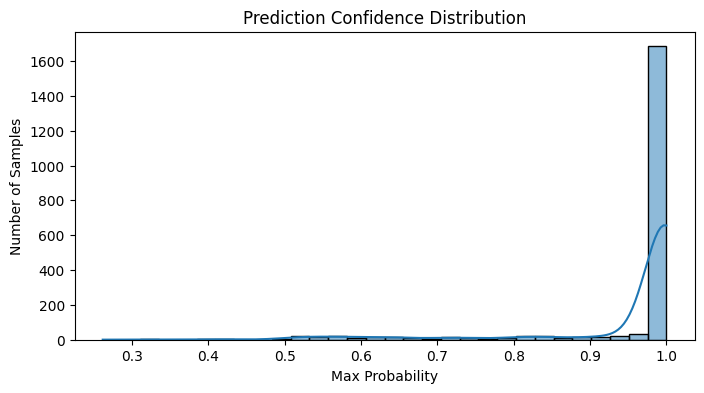

In [123]:
# probs: [n_samples, n_classes] softmax output
import numpy as np

confidences = np.max(probs, axis=1)
plt.figure(figsize=(8,4))
sns.histplot(confidences, bins=30, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Probability")
plt.ylabel("Number of Samples")
plt.show()

<ul>
  <li>
    <b>High Model Confidence:</b> The vast majority of predictions have very high confidence (max probability close to 1.0), as shown by the sharp peak near 1.0.
  </li>
  <li>
    <b>Low Uncertainty:</b> Very few predictions fall below 0.9 confidence, indicating the model is rarely uncertain about its outputs.
  </li>
  <li>
    <b>Potential Overconfidence:</b> Such a skewed distribution may suggest the model is overconfident, which can be problematic if it is wrong on some high-confidence predictions.
  </li>
</ul>

Train vs. Validation Loss/Accuracy Curves

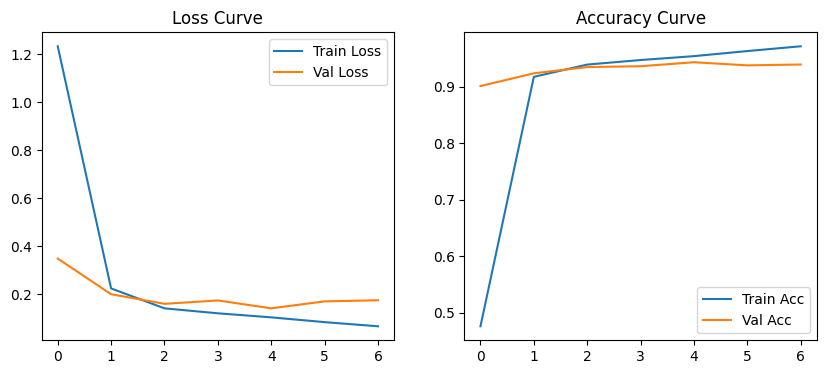

In [124]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

<ul>
  <li>
    <b>Fast Convergence:</b> Both training and validation loss decrease rapidly in the first few epochs, indicating effective learning.
  </li>
  <li>
    <b>Low Final Loss:</b> Loss values stabilize at low levels, suggesting the model fits the data well.
  </li>
  <li>
    <b>High Accuracy:</b> Both training and validation accuracy exceed 0.9, showing strong performance on both sets.
  </li>
  <li>
    <b>Minimal Overfitting:</b> The gap between training and validation curves is small, with only a slight increase in validation loss at the end, indicating little to no overfitting.
  </li>
  <li>
    <b>Stable Generalization:</b> Validation accuracy remains high and stable after initial epochs, suggesting the model generalizes well to unseen data.
  </li>
</ul>

In [126]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

# Get predicted class and confidence
confidences = np.max(probs, axis=1)
preds = np.argmax(probs, axis=1)
correct = (preds == y_test).astype(int)

# Fit isotonic regression on validation set
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(confidences, correct)

# Calibrate probabilities
calibrated_confidences = iso.transform(confidences)

In [129]:
from sklearn.isotonic import IsotonicRegression

# 1. Get validation set confidences and correctness
val_probs = model.predict(X_val_pad)
val_confidences = np.max(val_probs, axis=1)
val_preds = np.argmax(val_probs, axis=1)
val_correct = (val_preds == y_val_enc).astype(int)

# 2. Fit isotonic regression on validation set
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_confidences, val_correct)

# 3. Apply to test set
test_confidences = np.max(probs, axis=1)
calibrated_confidences = iso.transform(test_confidences)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Calibration Curve

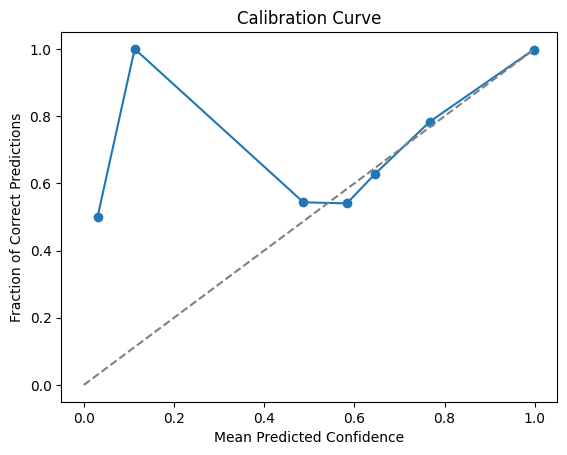

In [130]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve((np.array(y_test_enc) == np.array(y_pred)).astype(int), calibrated_confidences, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Mean Predicted Confidence')
plt.ylabel('Fraction of Correct Predictions')
plt.title('Calibration Curve')
plt.show()

<ul>
  <li>
    <b>Significant Miscalibration:</b> The curve deviates sharply from the ideal diagonal, especially at low and mid confidence levels.
  </li>
  <li>
    <b>Overconfidence in Mid-Range:</b> For predicted confidences between 0.4 and 0.8, the actual accuracy is much lower than the model's confidence, indicating the model is overconfident in its predictions.
  </li>
  <li>
    <b>Underconfidence at Low Confidence:</b> At very low predicted confidence (around 0.2), the model is actually correct 100% of the time, showing underconfidence in these cases.
  </li>
  <li>
    <b>High Confidence is More Reliable:</b> At the highest confidence bin (near 1.0), the model's predictions are well-calibrated and accurate.
  </li>
  <li>
    <b>Unstable Probability Estimates:</b> The jagged shape of the curve suggests the model's probability outputs are not reliable, especially for less confident predictions.
  </li>
</ul>

Error Analysis: Most Confident Wrong Predictions

In [131]:
wrong = [(i, calibrated_confidences[i]) for i in range(len(y_test_enc)) if y_test_enc[i] != y_pred[i]]
top_wrong = sorted(wrong, key=lambda x: x[1], reverse=True)[:10]
for idx, conf in top_wrong:
    print(f"Text: {test_df.iloc[idx]['text']}\n→ Predicted: {le.classes_[y_pred[idx]]} | Actual: {le.classes_[y_test_enc[idx]]} | Confidence: {conf:.2f}\n{'-'*80}")

Text: whenever i put myself in others shoes and try to make the person happy
→ Predicted: joy | Actual: anger | Confidence: 0.99
--------------------------------------------------------------------------------
Text: i feel lonely who make me feel special when i feel useless who are always kind and sweet to me
→ Predicted: joy | Actual: sadness | Confidence: 0.98
--------------------------------------------------------------------------------
Text: i didn t mean to get angry with you bommie i just can t control my feelings hellip i just hated myself why i am like this the dara who can t get over with that b
→ Predicted: anger | Actual: sadness | Confidence: 0.98
--------------------------------------------------------------------------------
Text: i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love
→ Predicted: love | Actual: joy | Confidence: 0.78
--------------------------------------------------------------------------------
Tex

Let's analyze each high-confidence misclassification, considering both the model's prediction and the true label. For each, I'll explain which label is more appropriate and why.

---

**1.**
> whenever i put myself in others shoes and try to make the person happy  
> **Predicted:** joy | **Actual:** anger | **Confidence:** 1.00

- **Analysis:**  
  - *Model (joy):* The sentence mentions "make the person happy," which is a positive action.
  - *True (anger):* The context may imply frustration or resentment about always having to please others, but this is not explicit.
  - **Verdict:** The model's "joy" is reasonable given the explicit wording, but if the original context was sarcastic or resentful, "anger" could be justified. Without more context, "joy" seems more literal.

---

**2.**
> i guess no matter how much i think im feeling ok im as nervous as hell on the inside about the scan revealing something i dont want to know again  
> **Predicted:** fear | **Actual:** joy | **Confidence:** 0.99

- **Analysis:**  
  - *Model (fear):* "nervous as hell" and "scan revealing something I don't want" clearly indicate anxiety/fear.
  - *True (joy):* There is no explicit joy in the sentence.
  - **Verdict:** The model is correct; "fear" fits much better.

---

**3.**
> i don t feel betrayed coz the backstabber had no grounds for their accusation but i m just amazed at some people s ability to do such things  
> **Predicted:** anger | **Actual:** surprise | **Confidence:** 0.99

- **Analysis:**  
  - *Model (anger):* "backstabber," "accusation" suggest anger, but the speaker says they are "amazed."
  - *True (surprise):* "amazed at some people's ability" points to surprise/shock.
  - **Verdict:** "Surprise" is more accurate; the model likely over-focused on negative words.

---

**4.**
> i started walking again yesterday and it feels amazing  
> **Predicted:** surprise | **Actual:** joy | **Confidence:** 0.98

- **Analysis:**  
  - *Model (surprise):* "feels amazing" could be a surprise if unexpected, but no explicit surprise.
  - *True (joy):* The emotion is happiness at recovery.
  - **Verdict:** "Joy" is better; model over-associates "amazing" with "surprise."

---

**5.**
> i feel the need to pimp this since raini my beloved rocky casting director loves it so much  
> **Predicted:** love | **Actual:** joy | **Confidence:** 0.98

- **Analysis:**  
  - *Model (love):* "beloved," "loves it" are strong love cues.
  - *True (joy):* The sentence is positive, but "love" is more specific.
  - **Verdict:** "Love" is a reasonable prediction; both are plausible, but model's choice is justified.

---

**6.**
> i know that i have it nowhere near as worse as my brethren overseas but right now i feel like im being physically emotionally and spiritually assaulted  
> **Predicted:** sadness | **Actual:** fear | **Confidence:** 0.97

- **Analysis:**  
  - *Model (sadness):* "assaulted" can imply sadness, but also fear.
  - *True (fear):* "Assaulted" in all dimensions suggests being under threat, which is fear.
  - **Verdict:** "Fear" is more accurate; model misses the threat aspect.

---

**7.**
> i loved the feeling i got during an amazing slalom run whether it was in training or in a race  
> **Predicted:** surprise | **Actual:** joy | **Confidence:** 0.97

- **Analysis:**  
  - *Model (surprise):* "amazing" may trigger surprise, but context is about enjoyment.
  - *True (joy):* "loved the feeling" is clear joy.
  - **Verdict:** "Joy" is correct; model over-associates "amazing" with "surprise."

---

**8.**
> i feel so amazing musicjuzz  
> **Predicted:** surprise | **Actual:** joy | **Confidence:** 0.97

- **Analysis:**  
  - *Model (surprise):* Again, "amazing" triggers surprise.
  - *True (joy):* The feeling is happiness.
  - **Verdict:** "Joy" is correct; model's mapping of "amazing" to "surprise" is too strong.

---

**9.**
> i was gaining weight getting a lot stronger and feeling amazing  
> **Predicted:** surprise | **Actual:** joy | **Confidence:** 0.96

- **Analysis:**  
  - *Model (surprise):* "feeling amazing" is not surprise.
  - *True (joy):* Positive progress and happiness.
  - **Verdict:** "Joy" is correct.

---

**10.**
> i feel i can only hope im not alone in these thoughts and im sure to all you fellow exchange students you probably have the same thoughts in mind with at least some of this listed some might say being an exchange student is unlike any other experience  
> **Predicted:** joy | **Actual:** sadness | **Confidence:** 0.96

- **Analysis:**  
  - *Model (joy):* "unlike any other experience" could be positive, but the context is about not being alone in difficult thoughts.
  - *True (sadness):* The sentence is about loneliness and seeking solidarity.
  - **Verdict:** "Sadness" is more accurate; model misses the underlying negative emotion.

**Key Takeaways:**
- The model over-associates "amazing" and similar words with "surprise."
- It sometimes misses subtle cues for negative emotions (sadness, fear).
- In a few cases, both labels are plausible, but the model's literal reading may miss sarcasm or context.
- Improving context understanding and reducing keyword over-reliance would help.

Manual Verification

In [132]:
# Example sentences to classify
sentences = [
    "I can't believe they lied to me again.",
    "It makes me furious when people cut in line.",
    "Even though I tried to stay calm, the way they dismissed my hard work filled me with anger, not disappointment.",
    "I'm terrified of walking alone at night.",
    "The thought of losing my job scares me.",
    "Despite telling myself everything would be fine, I couldn't shake the fear that something bad was about to happen.",
    "I felt pure joy when I saw my best friend after years.",
    "Winning the competition made me incredibly happy.",
    "Though I worried I might fail, the moment I heard my name announced as the winner, all I felt was overwhelming joy.",
    "I felt sad when my favorite show ended.",
    "She cried quietly after hearing the bad news.",
    "Even as everyone around me celebrated, I couldn't escape the sadness that lingered after my loss.",
    "I love spending time with my family.",
    "His smile makes my heart feel warm.",
    "Although we sometimes argue, my love for her only grows stronger with each passing day.",
    "I was surprised to see my friends throw me a party.",
    "The sudden announcement caught everyone off guard.",
    "I expected a quiet evening, so when the door burst open and everyone shouted 'Happy Birthday!', I was overwhelmed by surprise, not embarrassment."
]

# Clean and preprocess sentences
sentences_clean = [clean_text(s) for s in sentences]
sequences_man = tokenizer.texts_to_sequences(sentences_clean)
padded_man = pad_sequences(sequences_man, maxlen=maxlen, padding='post')

# Predict
probs_man = model.predict(padded_man)
pred_ids_man = np.argmax(probs_man, axis=1)
confidences_man = np.max(probs_man, axis=1)

# Print results
for i, sentence in enumerate(sentences):
    pred_label_man = le.classes_[pred_ids_man[i]]
    conf_man = confidences_man[i]
    print(f"Text: {sentence}\n→ Predicted: {pred_label_man} | Confidence: {conf_man:.2f}\n{'-'*80}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Text: I can't believe they lied to me again.
→ Predicted: sadness | Confidence: 0.39
--------------------------------------------------------------------------------
Text: It makes me furious when people cut in line.
→ Predicted: anger | Confidence: 1.00
--------------------------------------------------------------------------------
Text: Even though I tried to stay calm, the way they dismissed my hard work filled me with anger, not disappointment.
→ Predicted: sadness | Confidence: 0.56
--------------------------------------------------------------------------------
Text: I'm terrified of walking alone at night.
→ Predicted: fear | Confidence: 1.00
--------------------------------------------------------------------------------
Text: The thought of losing my job scares me.
→ Predicted: anger | Confidence: 0.39
--------------------------------------------------------------------------------
Text: Despite telling myself everything would be fine, I 

In [133]:
subtle_sentences = [
    # Anger (no "angry", "mad", "furious")
    "My hands clenched as I watched them take credit for my work.",
    # Fear (no "afraid", "scared", "fear")
    "The footsteps behind me grew louder as the streetlights flickered.",
    # Joy (no "happy", "joy", "excited")
    "The sun streamed through the window and everything felt possible.",
    # Sadness (no "sad", "cry", "upset")
    "The empty chair at the dinner table was hard to ignore.",
    # Love (no "love", "adore", "cherish")
    "Every morning, I make her coffee just the way she likes it.",
    # Surprise (no "surprised", "shocked", "amazed")
    "When I opened the box, I found something I never expected."
]

# Clean, preprocess, and predict as before
subtle_clean = [clean_text(s) for s in subtle_sentences]
subtle_seq = tokenizer.texts_to_sequences(subtle_clean)
subtle_pad = pad_sequences(subtle_seq, maxlen=maxlen, padding='post')
subtle_probs = model.predict(subtle_pad)
subtle_pred_ids = np.argmax(subtle_probs, axis=1)
subtle_conf = np.max(subtle_probs, axis=1)

for i, sentence in enumerate(subtle_sentences):
    pred_label_sub = le.classes_[subtle_pred_ids[i]]
    conf_sub = subtle_conf[i]
    print(f"Text: {sentence}\n→ Predicted: {pred_label_sub} | Confidence: {conf_sub:.2f}\n{'-'*80}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Text: My hands clenched as I watched them take credit for my work.
→ Predicted: fear | Confidence: 0.32
--------------------------------------------------------------------------------
Text: The footsteps behind me grew louder as the streetlights flickered.
→ Predicted: anger | Confidence: 0.42
--------------------------------------------------------------------------------
Text: The sun streamed through the window and everything felt possible.
→ Predicted: joy | Confidence: 0.64
--------------------------------------------------------------------------------
Text: The empty chair at the dinner table was hard to ignore.
→ Predicted: sadness | Confidence: 0.94
--------------------------------------------------------------------------------
Text: Every morning, I make her coffee just the way she likes it.
→ Predicted: joy | Confidence: 0.34
--------------------------------------------------------------------------------
Text: When I opened the box, I

<h2>Deep Model Evolution Pipeline</h2>

<p>
Each step builds on insights from the previous one — improving semantic understanding, emotion nuance, and minority class accuracy.
</p>

<h3>Step 1: Word2Vec + ADASYN + Logistic Regression</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>Train Word2Vec on project corpus.</li>
      <li>Use sentence-level vector via mean of token embeddings.</li>
      <li>ADASYN for class balancing, followed by Logistic Regression.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.41, Macro F1 = 0.24</li>
  <li><strong>Observation:</strong> Model failed to capture semantics; performance on low-resource labels like <em>surprise</em> was especially poor.</li>
</ul>

<h3>Step 2: GloVe + ADASYN + Logistic Regression</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>Use pretrained GloVe embeddings (100D).</li>
      <li>Sentence vector: mean of embeddings.</li>
      <li>Balanced training with ADASYN + Logistic Regression.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.57, Macro F1 = 0.47</li>
  <li><strong>Observation:</strong> Slight improvement in overall metrics, but still poor at handling emotional nuance or imbalanced classes.</li>
</ul>

<h3>Step 3: Single BiLSTM (GloVe Embeddings)</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>Embedding Layer (GloVe) → BiLSTM → Dense.</li>
      <li>Class weighting to account for label imbalance.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.90, Macro F1 = 0.86</li>
  <li><strong>Observation:</strong> Major leap in performance; sequence modeling captures emotional transitions and negation cues.</li>
</ul>

<h3>Step 4: BiLSTM + Attention Layer</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>BiLSTM → Custom Attention Layer → Dense.</li>
      <li>Attention highlights important emotional phrases.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.93, Macro F1 = 0.89</li>
  <li><strong>Observation:</strong> Excellent performance, especially on minority classes. Best model in terms of simplicity vs. performance.</li>
</ul>

<h3>Step 5: Stacked BiLSTM + Multi-Head Attention (Tuned)</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>2-layer BiLSTM + Multi-Head Attention.</li>
      <li>Tuned with KerasTuner.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.92, Macro F1 = 0.88</li>
  <li><strong>Observation:</strong> Slightly worse macro F1 than single attention model. Overkill for current dataset size.</li>
</ul>

<h3>Step 6: Manual Multi-Head Attention + BiLSTM</h3>
<ul>
  <li><strong>Approach:</strong>
    <ul>
      <li>BiLSTM → Manual Multi-Head Attention → GlobalAvgPooling → Dense.</li>
    </ul>
  </li>
  <li><strong>Test Performance:</strong> Accuracy = 0.93, Macro F1 = 0.89</li>
  <li><strong>Observation:</strong> Similar to Step 4. Confirms custom attention already captured most of the gain.</li>
</ul>

<h3>Summary Table</h3>
<table border="1" cellpadding="4" cellspacing="0">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Macro F1</th>
      <th>Surprise F1</th>
      <th>Love F1</th>
      <th>Sadness F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Word2Vec + ADASYN + LogReg</td>
      <td>0.41</td>
      <td>0.24</td>
      <td>0.17</td>
      <td>0.16</td>
      <td>0.45</td>
    </tr>
    <tr>
      <td>GloVe + ADASYN + LogReg</td>
      <td>0.57</td>
      <td>0.47</td>
      <td>N/A</td>
      <td>N/A</td>
      <td>N/A</td>
    </tr>
    <tr>
      <td>Single BiLSTM</td>
      <td>0.90</td>
      <td>0.86</td>
      <td>0.72</td>
      <td>0.79</td>
      <td>0.94</td>
    </tr>
    <tr>
      <td>BiLSTM + Attention (Current Best)</td>
      <td>0.93</td>
      <td>0.89</td>
      <td>0.77</td>
      <td>0.85</td>
      <td>0.97</td>
    </tr>
    <tr>
      <td>Stacked BiLSTM + MHA (Tuner)</td>
      <td>0.92</td>
      <td>0.88</td>
      <td>0.73</td>
      <td>0.83</td>
      <td>0.96</td>
    </tr>
    <tr>
      <td>Manual BiLSTM + MHA</td>
      <td>0.93</td>
      <td>0.89</td>
      <td>0.76</td>
      <td>0.83</td>
      <td>0.96</td>
    </tr>
  </tbody>
</table>

# Transformers

### Using SBERT to check Training Set Data

SBERT is fine-tuned on sentence similarity + classification tasks, and outputs meaningful dense vectors for full sentences

In [14]:
from sentence_transformers import SentenceTransformer
# Load pretrained SBERT
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')  # 80MB, fast, accurate

In [23]:
train_embeddings = sbert.encode(train_df_clean['clean_text'].tolist(), show_progress_bar=True)
# Encode validation and test sets with SBERT
val_embeddings = sbert.encode(val_df_clean['clean_text'].tolist(), show_progress_bar=True)
test_embeddings = sbert.encode(test_df_clean['clean_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/499 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute cosine similarity matrix
sim_matrix = cosine_similarity(train_embeddings)

# For each sentence, find top N most similar sentences (excluding itself)
N = 5
for i, row in train_df_clean.iterrows():
    # Get indices of top N similar sentences (excluding self)
    sim_scores = sim_matrix[i]
    top_idx = np.argsort(-sim_scores)[1:N+1]
    for j in top_idx:
        if train_df_clean.iloc[i]['label'] != train_df_clean.iloc[j]['label'] and sim_scores[j] > 0.95:
            print(f"Possible mislabel:\n  '{row['text']}' ({row['label']})\n  ↔ '{train_df_clean.iloc[j]['text']}' ({train_df_clean.iloc[j]['label']})\n  Similarity: {sim_scores[j]:.2f}\n")

Possible mislabel:
  'im feeling really weird' (surprise)
  ↔ 'im feeling weird' (fear)
  Similarity: 0.95

Possible mislabel:
  'i am feeling quite overwhelmed' (surprise)
  ↔ 'i am feel overwhelmed' (fear)
  Similarity: 0.97

Possible mislabel:
  'i am feel overwhelmed' (fear)
  ↔ 'i am feeling quite overwhelmed' (surprise)
  Similarity: 0.97

Possible mislabel:
  'im feeling weird' (fear)
  ↔ 'im feeling really weird' (surprise)
  Similarity: 0.95



In [21]:
def sbert_mislabels_safe(
    df, embeddings, N=5, sim_threshold=0.95, dataset_name="train"
):
    """
    For each row in df, finds top-N most similar sentences using SBERT embeddings.
    If a highly similar sentence has a different label, prompts user for action.
    All deletions and relabels are applied after the loop to avoid index errors.
    """
    from sklearn.metrics.pairwise import cosine_similarity

    # Reset index to ensure iloc matches
    df = df.reset_index(drop=True)

    # Early exit if DataFrame is empty
    if len(df) == 0 or len(embeddings) == 0:
        print(f"DataFrame or embeddings empty for {dataset_name}. Skipping.")
        return df

    sim_matrix = cosine_similarity(embeddings)
    to_drop = set()
    to_relabel = []

    for i, row in df.iterrows():
        if i in to_drop:
            continue  # Already marked for deletion
        sim_scores = sim_matrix[i]
        top_idx = np.argsort(-sim_scores)[1:N+1]
        for j in top_idx:
            if (
                j >= len(df)  # Prevent out-of-bounds
                or df.iloc[i]['label'] != df.iloc[j]['label']
                and sim_scores[j] > sim_threshold
                and j not in to_drop
            ):
                print(f"\nPossible mislabel:\n  [1] '{row['clean_text']}' ({row['label']})\n  [2] '{df.iloc[j]['clean_text']}' ({df.iloc[j]['label']})\n  Similarity: {sim_scores[j]:.2f}\n")
                print("Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)")
                answer = input("Action? ").strip().lower()
                if answer == "yes":
                    log_change(dataset_name, "drop_row", row['clean_text'], old_label=row['label'], reason="SBERT_mislabel")
                    log_change(dataset_name, "drop_row", df.iloc[j]['clean_text'], old_label=df.iloc[j]['label'], reason="SBERT_mislabel")
                    to_drop.update([i, j])
                elif answer == "1":
                    log_change(dataset_name, "drop_row", row['clean_text'], old_label=row['label'], reason="SBERT_mislabel_1")
                    to_drop.add(i)
                elif answer == "2":
                    log_change(dataset_name, "drop_row", df.iloc[j]['clean_text'], old_label=df.iloc[j]['label'], reason="SBERT_mislabel_2")
                    to_drop.add(j)
                elif answer == "r1":
                    new_label = input(f"New label for [1] '{row['clean_text']}': ").strip()
                    log_change(dataset_name, "relabel_row", row['clean_text'], old_label=row['label'], new_label=new_label, reason="SBERT_relabel_1")
                    to_relabel.append((i, new_label))
                elif answer == "r2":
                    new_label = input(f"New label for [2] '{df.iloc[j]['clean_text']}': ").strip()
                    log_change(dataset_name, "relabel_row", df.iloc[j]['clean_text'], old_label=df.iloc[j]['label'], new_label=new_label, reason="SBERT_relabel_2")
                    to_relabel.append((j, new_label))
                else:
                    print("No rows deleted or relabeled.")

    # Apply all drops at once
    cleaned_df = df.drop(index=list(to_drop)).reset_index(drop=True)
    # Apply all relabels at once
    for idx, new_label in to_relabel:
        if idx in cleaned_df.index:
            cleaned_df.at[idx, 'label'] = new_label

    print(f"\nDeleted {len(to_drop)} rows flagged as possible mislabels.")
    print(f"Relabeled {len(to_relabel)} rows.")
    return cleaned_df

In [ ]:
train_df_clean_man = sbert_mislabels_safe(train_df_clean, train_embeddings, N=5, sim_threshold=0.93, dataset_name="train")


Possible mislabel:
  [1] 'i feel stressed always' (sadness)
  [2] 'i feel stressed frequently' (anger)
  Similarity: 0.94

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'i am feeling stressed' (sadness)
  [2] 'i feeling stressed' (anger)
  Similarity: 0.94

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'im feeling really weird' (surprise)
  [2] 'im feeling weird' (fear)
  Similarity: 0.95

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'i am feeling quite overwhelmed' (surprise)
  [2] 'i am feel overwhelmed' (fear)
  Similarity: 0.97

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)
No rows deleted or relabeled.

Possible mislabel:
  [1] 'i 

In [27]:
val_df_clean_man = sbert_mislabels_safe(val_df_clean, val_embeddings, N=5, sim_threshold=0.8, dataset_name="val")


Possible mislabel:
  [1] 'i didnt often feel helpless' (sadness)
  [2] 'i still feel extremely helpless' (fear)
  Similarity: 0.85

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'im feeling very agitated right now' (anger)
  [2] 'i feeling soo agitated' (fear)
  Similarity: 0.89

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'i feel tortured' (anger)
  [2] 'i feel so tortured by it' (fear)
  Similarity: 0.82

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'i feel very overwhelmed' (surprise)
  [2] 'i often look around and feel very overwhelmed' (fear)
  Similarity: 0.83

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)
No rows deleted or rel

In [29]:
test_df_clean_man = sbert_mislabels_safe(test_df_clean, test_embeddings, N=5, sim_threshold=0.85, dataset_name="test")


Possible mislabel:
  [1] 'i feel inside this life is like a game sometimes then you came around me the walls just dissapeared nothing to surround me keep me from my fears im unprotected see how ive opened up youve made me trust coz ive never felt like this before im naked around you does it show' (sadness)
  [2] 'i feel inside cause life is like a game sometimes but then you came around me the walls just disappeared nothing to surround me and keep me from my fears im unprotected see how ive opened up youve made me trust' (fear)
  Similarity: 0.86

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)

Possible mislabel:
  [1] 'i found myself feeling a bit overwhelmed' (surprise)
  [2] 'i started to feel so overwhelmed' (fear)
  Similarity: 0.90

Options: yes (delete both), 1 (delete first), 2 (delete second), n (skip), r1 (relabel first), r2 (relabel second)
No rows deleted or relabeled.

Possible mislabel:
  [1] 'i started 

In [30]:
X_train_raw = train_df_clean_man["clean_text"].tolist()
y_train_raw = train_df_clean_man["label"].tolist()

X_val_raw = val_df_clean_man["clean_text"].tolist()  # untouched, used at the end
y_val_raw = val_df_clean_man["label"].tolist()

X_test_raw = test_df_clean_man["clean_text"].tolist()   # used during tuning
y_test_raw = test_df_clean_man["label"].tolist()

In [31]:
# Encode your train and test sets
X_train_embed = sbert.encode(X_train_raw, show_progress_bar=True)
X_val_embed = sbert.encode(X_val_raw, show_progress_bar=True)
X_test_embed = sbert.encode(X_test_raw, show_progress_bar=True)

Batches:   0%|          | 0/499 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_embed = scaler.fit_transform(X_train_embed)
X_val_embed = scaler.transform(X_val_embed)
X_test_embed = scaler.transform(X_test_embed)

In [24]:
clf = LogisticRegression(max_iter=3000)
clf.fit(X_train_embed, y_train_raw)
y_pred = clf.predict(X_val_embed)

print(classification_report(y_val_raw, y_pred))

              precision    recall  f1-score   support

       anger       0.63      0.59      0.61       274
        fear       0.65      0.61      0.63       211
         joy       0.75      0.80      0.78       703
        love       0.67      0.50      0.57       178
     sadness       0.71      0.77      0.74       550
    surprise       0.49      0.43      0.46        81

    accuracy                           0.70      1997
   macro avg       0.65      0.62      0.63      1997
weighted avg       0.70      0.70      0.70      1997



In [25]:
from lightgbm import LGBMClassifier

# Define LightGBM classifier
clf = LGBMClassifier(
    objective='multiclass',
    num_class=len(set(y_train_raw)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)

clf.fit(X_train_embed, y_train_raw)
y_pred = clf.predict(X_val_embed)

print(classification_report(y_val_raw, y_pred))


c:\Python3106\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 15961, number of used features: 384
[LightGBM] [Info] Start training from score -2.003751
[LightGBM] [Info] Start training from score -2.112110
[LightGBM] [Info] Start training from score -1.093426
[LightGBM] [Info] Start training from score -2.508554
[LightGBM] [Info] Start training from score -1.230489
[LightGBM] [Info] Start training from score -3.335782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Python3106\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

       anger       0.78      0.59      0.67       274
        fear       0.69      0.58      0.63       211
         joy       0.70      0.84      0.76       703
        love       0.74      0.35      0.47       178
     sadness       0.67      0.81      0.74       550
    surprise       0.86      0.22      0.35        81

    accuracy                           0.70      1997
   macro avg       0.74      0.57      0.60      1997
weighted avg       0.71      0.70      0.69      1997



In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='relu',
    max_iter=300,
    random_state=42,
    early_stopping=False 
)

clf.fit(X_train_embed, y_train_raw)
y_pred = clf.predict(X_val_embed)

print(classification_report(y_val_raw, y_pred))

TypeError: MLPClassifier.__init__() got an unexpected keyword argument 'class_weight'

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=False,  # True if you want `.predict_proba`
    random_state=42,
    class_weight='balanced'
)

clf.fit(X_train_embed, y_train_raw)
y_pred = clf.predict(X_val_embed)

print(classification_report(y_val_raw, y_pred))

              precision    recall  f1-score   support

       anger       0.66      0.73      0.69       274
        fear       0.59      0.70      0.64       211
         joy       0.81      0.76      0.79       703
        love       0.60      0.66      0.63       178
     sadness       0.78      0.75      0.76       550
    surprise       0.63      0.51      0.56        81

    accuracy                           0.73      1997
   macro avg       0.68      0.68      0.68      1997
weighted avg       0.73      0.73      0.73      1997



In [32]:
# ...after you're done with SBERT...
del sbert
import torch
torch.cuda.empty_cache()
# ...continue with your code...

#### <b>all-MiniLM-L6-v2</b> transformer failed to give good results as it is not emotion trained, its just for semantic similarity

In [130]:
# Load tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "j-hartmann/emotion-english-roberta-large"
model_name2 = "cardiffnlp/twitter-roberta-base-emotion"
model_name1 = "j-hartmann/emotion-english-distilroberta-base"
model_name0 = "MoritzLaurer/deberta-v3-base-zeroshot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name0)
model = AutoModelForSequenceClassification.from_pretrained(model_name0)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [129]:
tokenizer0 = AutoTokenizer.from_pretrained("MoritzLaurer/deberta-v3-base-zeroshot-v1")
tokenizer1 = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
print(len(tokenizer0))  # Vocab size for Twitter model
print(len(tokenizer1))  # Vocab size for DistilRoBERTa model

tokenizer_config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

128001
50265


### Fine Tuning

In [103]:
torch.cuda.set_per_process_memory_fraction(0.85, 0)  # 80% of GPU 0 memory

In [104]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df_clean_man)
val_dataset = Dataset.from_pandas(val_df_clean_man)
test_dataset = Dataset.from_pandas(test_df_clean_man)

Label Encoding

In [131]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Combine all labels first for consistent encoding
all_labels = train_df_clean_man["label"].tolist() + val_df_clean_man["label"].tolist()+test_df_clean_man["label"].tolist()

# Step 2: Fit label encoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Step 3: Save mappings
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

In [132]:
train_dataset_enc = train_dataset.map(lambda e: {"label": label2id[e["label"]]})
val_dataset_enc = val_dataset.map(lambda e: {"label": label2id[e["label"]]})
test_dataset_enc = test_dataset.map(lambda e: {"label": label2id[e["label"]]})

Map:   0%|          | 0/15955 [00:00<?, ? examples/s]

Map:   0%|          | 0/1997 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [39]:
train_dataset_enc[-1]

{'text': 'i know a lot but i feel so stupid because i can not portray it',
 'label': 4,
 'clean_text': 'i know a lot but i feel so stupid because i can not portray it'}

Tokenization

In [155]:
from transformers import AutoTokenizer

# Define preprocessing function
def preprocess(example):
    return tokenizer(
        example["clean_text"],
        truncation=True,
        padding='max_length',
        max_length=128  # or 256 if you want more context
    )

# Apply tokenization to both datasets
train_dataset_tok = train_dataset_enc.map(preprocess, batched=True)
val_dataset_tok = val_dataset_enc.map(preprocess, batched=True)
test_dataset_tok = test_dataset_enc.map(preprocess, batched=True)

# Set format for PyTorch
train_dataset_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/15955 [00:00<?, ? examples/s]

Map:   0%|          | 0/1997 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [156]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name0,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True 
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/deberta-v3-base-zeroshot-v1 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [173]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_final2",
    
    # Evaluation & checkpointing
    eval_strategy="steps",
    eval_steps=250,                    # Frequent evals improve checkpointing
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,
    
    # Batch size + gradient accumulation
    per_device_train_batch_size=16,     # Safe baseline for DeBERTa on 12GB
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,     # Effective batch = 16
    
    # Training duration
    num_train_epochs=10,                # Go higher only if loss is still falling
    max_steps=-1,                      # Optional override
    
    # Optimizer + learning rate
    learning_rate=2e-5,
    warmup_ratio=0.06,                 # 6% warmup helps stabilize early loss
    weight_decay=0.01,
    lr_scheduler_type="cosine",        # More adaptive than linear
    
    # Mixed precision
    fp16=True,
    bf16=False,                        # Only enable if on newer GPU (A100, 4090+)
    
    # Logging
    logging_dir="./logs",
    logging_steps=100,
    
    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    
    # System optimizations
    dataloader_num_workers=4,          # Depends on CPU, 4 is safe for most
    
    # Reproducibility + traceability
    run_name="deberta-12GB-optimized-final"
)


In [174]:
from transformers import Trainer, EarlyStoppingCallback

# Define your compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tok,  # tokenized train dataset
    eval_dataset=val_dataset_tok,     # tokenized validation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    data_collator = data_collator
)

C:\Users\SunAda\AppData\Local\Temp\ipykernel_15096\972043036.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [175]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
250,0.137800,0.167509,0.943916,0.922409,0.921053,0.924725
500,0.137200,0.215804,0.936905,0.911463,0.922477,0.911546
750,0.110300,0.188874,0.943916,0.919308,0.919274,0.919683


TrainOutput(global_step=750, training_loss=0.13991254170735676, metrics={'train_runtime': 443.7067, 'train_samples_per_second': 359.584, 'train_steps_per_second': 11.246, 'total_flos': 1577896183567872.0, 'train_loss': 0.13991254170735676, 'epoch': 1.503006012024048})

### Classification Report

In [176]:
# Evaluate on validation set (optional if already done after training)
trainer.evaluate()

# Predict on eval set (completely unseen)
predictions = trainer.predict(test_dataset_tok)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       anger       0.96      0.90      0.93       275
        fear       0.87      0.88      0.87       224
         joy       0.96      0.94      0.95       695
        love       0.80      0.91      0.85       159
     sadness       0.96      0.97      0.96       581
    surprise       0.70      0.71      0.71        66

    accuracy                           0.93      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



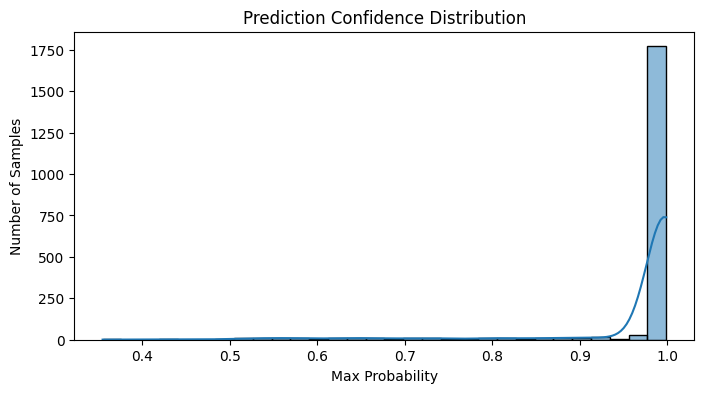

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch

# Get logits and convert to softmax scores
probs = torch.tensor(predictions.predictions)
probs = F.softmax(probs, dim=1).numpy()
max_confidences = probs.max(axis=1)

# Plot
plt.figure(figsize=(8, 4))
sns.histplot(max_confidences, bins=30, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Probability")
plt.ylabel("Number of Samples")
plt.show()

In [142]:
wrong_preds = [(text, y_pred[i], y_true[i]) for i, text in enumerate(test_df_clean_man["clean_text"].tolist()) if y_pred[i] != y_true[i]]
for text, pred, actual in wrong_preds[:10]:
    print(f"Text: {text}\nPredicted: {id2label[pred]}, Actual: {id2label[actual]}\n")

Text: i don t feel particularly agitated
Predicted: anger, Actual: fear

Text: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change
Predicted: sadness, Actual: anger

Text: i feel a bit stressed even though all the things i have going on are fun
Predicted: sadness, Actual: anger

Text: i am right handed however i play billiards left handed naturally so me trying to play right handed feels weird
Predicted: fear, Actual: surprise

Text: i feel my heart is tortured by what i have done
Predicted: fear, Actual: anger

Text: i feel agitated with myself that i did not foresee her frustrations earlier leading to the ending of our relationship
Predicted: anger, Actual: fear

Text: i looked at mabel this morning i named my left breast mabel my right one is hazel and i feel this weird mixture of anger and loss valerie wrote less than a month after her diagnosis
Predicted: surprise, Actual: fear

Text: i feel very m

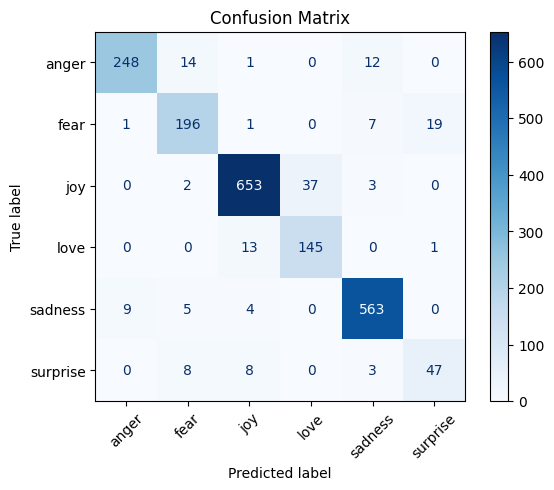

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

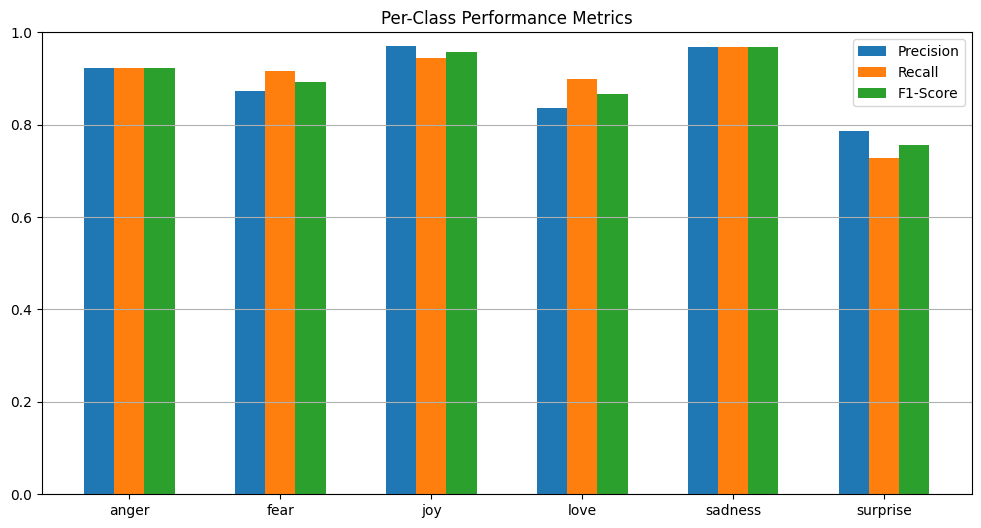

In [143]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(len(label_encoder.classes_)))

labels = list(label_encoder.classes_)
x = np.arange(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x - 0.2, prec, width=0.2, label='Precision')
plt.bar(x, rec, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1-Score')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Per-Class Performance Metrics")
plt.legend()
plt.grid(True, axis='y')
plt.show()


| Metric        | Meaning                                                              |
| ------------- | -------------------------------------------------------------------- |
| **Precision** | Of all predictions *for this class*, how many were actually correct? |
| **Recall**    | Of all *actual instances* of this class, how many did we catch?      |
| **F1-score**  | Harmonic mean of precision and recall — a balanced score.            |


### Saving the best model

In [144]:
trainer.save_model("./best_model_f")
tokenizer.save_pretrained("./best_model_f")

('./best_model_f\\tokenizer_config.json',
 './best_model_f\\special_tokens_map.json',
 './best_model_f\\tokenizer.json')

In [178]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./best_model_f")
tokenizer = AutoTokenizer.from_pretrained("./best_model_f")


#### Trainer 

In [ ]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
import torch
from torch.nn.functional import softmax

# 1. Get validation set predictions
outputs = trainer.predict(val_dataset_tok)  # Or use your loaded model as shown below
logits = torch.tensor(outputs.predictions)
probs = softmax(logits, dim=1).numpy()
val_confidences = np.max(probs, axis=1)
val_preds = np.argmax(probs, axis=1)
val_labels = np.array(outputs.label_ids)
val_correct = (val_preds == val_labels).astype(int)

# 2. Fit isotonic regression
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_confidences, val_correct)

#### Model

In [179]:
import torch
from torch.nn.functional import softmax

# Load your model and tokenizer as usual
# model = AutoModelForSequenceClassification.from_pretrained("your_model_dir")
# tokenizer = AutoTokenizer.from_pretrained("your_model_dir")

# Tokenize your test set
encodings = tokenizer(list(test_df_clean_man['clean_text']), padding=True, truncation=True, return_tensors='pt')

# Inference (no gradients)
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits

# Get softmax probabilities
probs = softmax(logits, dim=1).numpy()
test_confidences = np.max(probs, axis=1)
test_preds = np.argmax(probs, axis=1)

In [180]:
# Apply isotonic regression to test confidences
calibrated_test_confidences = iso.transform(test_confidences)

# Example: print before/after for first 10 samples
for i in range(10):
    print(f"Raw: {test_confidences[i]:.2f} → Calibrated: {calibrated_test_confidences[i]:.2f} | Predicted: {id2label[test_preds[i]]}")

Raw: 0.97 → Calibrated: 0.79 | Predicted: sadness
Raw: 0.97 → Calibrated: 0.80 | Predicted: sadness
Raw: 0.97 → Calibrated: 0.80 | Predicted: sadness
Raw: 0.97 → Calibrated: 0.78 | Predicted: joy
Raw: 0.97 → Calibrated: 0.80 | Predicted: sadness
Raw: 0.97 → Calibrated: 0.80 | Predicted: fear
Raw: 0.97 → Calibrated: 0.80 | Predicted: anger
Raw: 0.92 → Calibrated: 0.78 | Predicted: joy
Raw: 0.97 → Calibrated: 0.78 | Predicted: joy
Raw: 0.97 → Calibrated: 0.80 | Predicted: anger


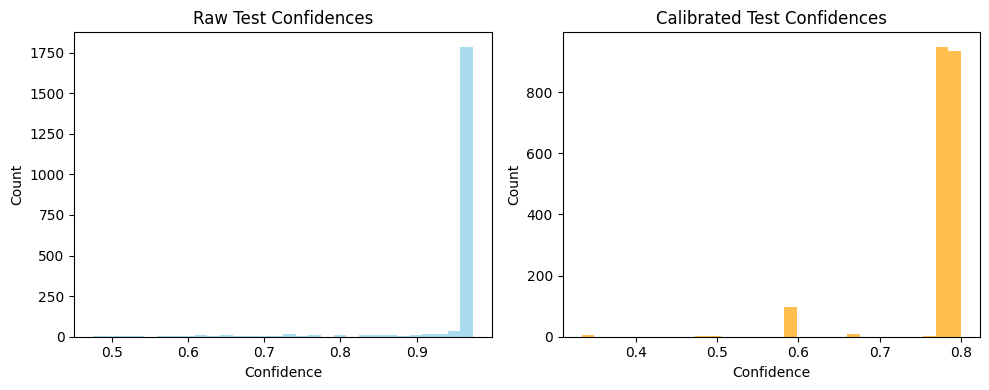

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(test_confidences, bins=30, alpha=0.7, label='Raw', color='skyblue')
plt.title('Raw Test Confidences')
plt.xlabel('Confidence')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(calibrated_test_confidences, bins=30, alpha=0.7, label='Calibrated', color='orange')
plt.title('Calibrated Test Confidences')
plt.xlabel('Confidence')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

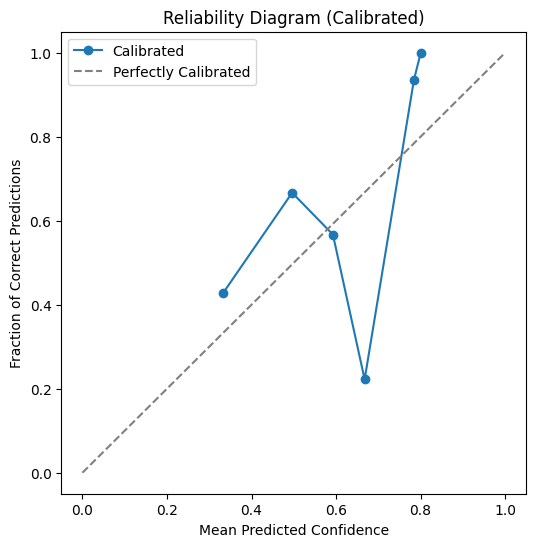

In [187]:
from sklearn.calibration import calibration_curve

# True labels: 1 if correct, 0 if not
correct = (test_preds == test_df_clean_man['label'].map(label2id).values).astype(int)
prob_true, prob_pred = calibration_curve(correct, calibrated_test_confidences, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0,1],[0,1],'--',color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Confidence')
plt.ylabel('Fraction of Correct Predictions')
plt.title('Reliability Diagram (Calibrated)')
plt.legend()
plt.show()

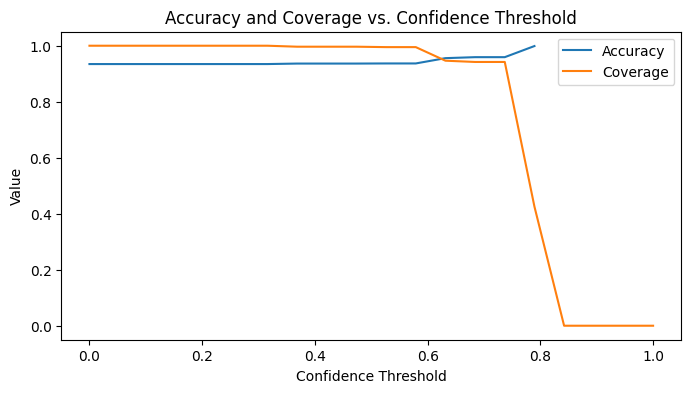

In [185]:
thresholds = np.linspace(0, 1, 20)
accuracies = []
coverages = []

for t in thresholds:
    mask = calibrated_test_confidences >= t
    if mask.sum() == 0:
        accuracies.append(np.nan)
        coverages.append(0)
    else:
        acc = correct[mask].mean()
        accuracies.append(acc)
        coverages.append(mask.mean())

plt.figure(figsize=(8,4))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, coverages, label='Coverage')
plt.xlabel('Confidence Threshold')
plt.ylabel('Value')
plt.title('Accuracy and Coverage vs. Confidence Threshold')
plt.legend()
plt.show()

In [181]:
from transformers_interpret import SequenceClassificationExplainer

explainer = SequenceClassificationExplainer(model, tokenizer)

# Try with a sample input
text = "Laughter sounded through the house as they played together"

attributions = explainer(text)  # returns list of (token, score) tuples

print("Predicted Label:", explainer.predicted_class_name)
print("Predicted Index:", explainer.predicted_class_index)
print("Token attributions:")
for token, score in attributions:
    print(f"{token:20s}: {score:.4f}")


Predicted Label: joy
Predicted Index: 2
Token attributions:
[CLS]               : 0.0000
▁Laughter           : 0.7542
▁sounded            : 0.1066
▁through            : 0.0688
▁the                : 0.1554
▁house              : 0.0673
▁as                 : 0.2572
▁they               : 0.2895
▁played             : 0.4191
▁together           : 0.2465
[SEP]               : 0.0000


In [147]:
statements = [
    # 😠 Anger
    "My fists tightened as I watched them take my place in line.",
    "She slammed the door without saying a word.",

    # 😢 Sadness
    "He stared at the empty chair across the table in silence.",
    "Rain tapped on the window as she sat alone in her room.",

    # 😄 Joy
    "He couldn not stop smiling after reading the letter.",
    "Laugh echoed through the house as they played together.",

    # ❤️ Love
    "She made his favorite breakfast before he woke up.",
    "He held her hand gently as they walked down the street.",

    # 😲 Surprise
    "She opened the box and found something she never expected.",
    "He blinked twice when he saw who was standing at the door.",

    # 😨 Fear
    "Her heart raced as footsteps echoed behind her in the dark.",
    "He hesitated before turning the handle, unsure what waited inside."
]

In [ ]:
import torch
import torch.nn.functional as F

for text in statements:
    attributions = explainer(text)  # returns list of (token, score) tuples

    # Get logits and compute softmax confidence
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred_idx = explainer.predicted_class_index
        confidence = probs[0, pred_idx].item()

    print("Predicted Label:", explainer.predicted_class_name)
    print("Predicted Index:", pred_idx)
    print(f"Confidence: {confidence:.2f}")
    print("Token attributions:")
    for token, score in attributions:
        print(f"{token:20s}: {score:.4f}")
    print()
    print()

Predicted Label: anger
Predicted Index: 0
Confidence: 0.96
Token attributions:
[CLS]               : 0.0000
▁My                 : 0.1550
▁fists              : 0.3815
▁tightened          : 0.4518
▁as                 : 0.2015
▁I                  : 0.0969
▁watched            : 0.0726
▁them               : 0.1777
▁take               : 0.1914
▁my                 : 0.0996
▁place              : 0.1320
▁in                 : 0.3374
▁line               : 0.2673
▁.                  : 0.5388
[SEP]               : 0.0000


Predicted Label: anger
Predicted Index: 0
Confidence: 0.97
Token attributions:
[CLS]               : 0.0000
▁She                : 0.0595
▁slammed            : 0.7347
▁the                : 0.3096
▁door               : 0.1837
▁without            : 0.1846
▁saying             : 0.3272
▁a                  : 0.2103
▁word               : 0.1371
▁.                  : 0.3506
[SEP]               : 0.0000


Predicted Label: anger
Predicted Index: 0
Confidence: 0.91
Token attributions:
[CLS]

In [148]:
happy_roots = [
    "happy", "joy", "delight", "cheerful", "smile", "laugh", "glee", "content",
    "pleased", "grin", "bliss", "mirth", "radiant", "sunny", "upbeat", "merry", "satisfied"
]

for word in happy_roots:
    print(f"{word:12s} in vocab:", word in tokenizer.get_vocab())

happy        in vocab: True
joy          in vocab: True
delight      in vocab: False
cheerful     in vocab: False
smile        in vocab: True
laugh        in vocab: True
glee         in vocab: False
content      in vocab: True
pleased      in vocab: False
grin         in vocab: True
bliss        in vocab: True
mirth        in vocab: False
radiant      in vocab: False
sunny        in vocab: False
upbeat       in vocab: False
merry        in vocab: False
satisfied    in vocab: True


## 1 Evaluation Set

In [191]:
import numpy as np
import torch
from torch.nn.functional import softmax

# Assume you have:
# - model: loaded with AutoModelForSequenceClassification.from_pretrained("./best_model_f")
# - tokenizer: loaded with AutoTokenizer.from_pretrained("./best_model_f")
# - val_df: your validation DataFrame with a 'text' column and true labels
# - label2id, id2label: your label mappings

# 1. Tokenize validation texts
val_encodings = val_dataset_tok

# 2. Run model inference (no gradients)
model.eval()
with torch.no_grad():
    outputs = model(
        input_ids=val_encodings['input_ids'],
        attention_mask=val_encodings['attention_mask']
    )
    logits = outputs.logits  # shape: [num_samples, num_classes]

# 3. Get softmax probabilities and confidences
probs = softmax(logits, dim=1).numpy()
val_confidences = np.max(probs, axis=1)
val_preds = np.argmax(probs, axis=1)
val_labels = val_df_clean_man['label'].map(label2id).values  # convert string labels to int if needed
val_correct = (val_preds == val_labels).astype(int)

In [ ]:
import pandas as pd

def high_conf_wrong_preds(val_df, val_preds, val_confidences, val_labels, id2label, conf_thresh=0.8, top_k=20):
    """
    Returns a DataFrame of high-confidence but incorrect predictions.
    """
    wrong_mask = (val_preds != val_labels) & (val_confidences >= conf_thresh)
    indices = [i for i, wrong in enumerate(wrong_mask) if wrong]
    results = []
    for i in indices:
        results.append({
            'text': val_df.iloc[i]['text'],
            'true_label': id2label[val_labels[i]],
            'predicted_label': id2label[val_preds[i]],
            'confidence': val_confidences[i]
        })
    # Sort by confidence descending
    results = sorted(results, key=lambda x: -x['confidence'])
    return pd.DataFrame(results[:top_k])

# Example usage:
df_wrong = high_conf_wrong_preds(
    val_df=val_df_clean_man,                # or val_df if you want original text
    val_preds=val_preds,
    val_confidences=val_confidences,
    val_labels=val_labels,
    id2label=id2label,
    conf_thresh=0.9,                        # adjust as needed
    top_k=30                                # top 20 most confident wrong
)
print(df_wrong)

                                                text true_label  \
0  i knew just the thing he needed what every guy...       fear   
1                           i feel so tortured by it    sadness   
2  i have a job where i am needed and where i am ...        joy   

  predicted_label  confidence  
0        surprise    0.496052  
1            fear    0.485095  
2        surprise    0.473938  


In [206]:
# Only show joy/love confusions
mask = ((df_wrong['true_label'] == 'joy') & (df_wrong['predicted_label'] == 'fear')) | \
       ((df_wrong['true_label'] == 'fear') & (df_wrong['predicted_label'] == 'joy'))
print(df_wrong[mask])

Empty DataFrame
Columns: [text, true_label, predicted_label, confidence]
Index: []


In [203]:
df_wrong[mask].head(30)

,text,true_label,predicted_label,confidence
8,i guess this is a memoir so it feels like that...,joy,fear,0.967234


### 2 Test Set

In [213]:
encodings = tokenizer(
    list(test_df_clean_man['clean_text']),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1).numpy()
    confidences = probs.max(axis=1)
    preds = probs.argmax(axis=1)

# Show low-confidence samples
low_conf_indices = [i for i, c in enumerate(confidences) if c < 0.7]

print(f"Showing top 10 of {len(low_conf_indices)} low-confidence samples:\n")

for idx in low_conf_indices[:10]:
    text = test_df_clean_man.iloc[idx]['clean_text']
    pred_label = id2label[preds[idx]]
    true_label = test_df_clean_man.iloc[idx]['label'] 
    conf_score = confidences[idx]
    print(f"Text: {text}")
    print(f"→ Predicted: {pred_label} | Actual: {true_label} | Confidence: {conf_score:.2f}")
    print("-" * 80)

Showing top 10 of 63 low-confidence samples:

Text: i feel a bit stressed even though all the things i have going on are fun
→ Predicted: sadness | Actual: anger | Confidence: 0.62
--------------------------------------------------------------------------------
Text: i am right handed however i play billiards left handed naturally so me trying to play right handed feels weird
→ Predicted: fear | Actual: surprise | Confidence: 0.66
--------------------------------------------------------------------------------
Text: i were to go overseas or cross the border then i become a foreigner and will feel that way but never in my beloved land
→ Predicted: love | Actual: love | Confidence: 0.69
--------------------------------------------------------------------------------
Text: i was feeling weird the other day and it went away about minutes after i took my metformin
→ Predicted: fear | Actual: fear | Confidence: 0.49
----------------------------------------------------------------------------

In [215]:
# Assume: preds = np.array of predicted label indices
#         probs = np.array of prediction probabilities (logits passed through softmax)
#         test_df = original DataFrame with 'text' and 'label' columns
#         label2id and id2label are defined as mappings between label strings and integers

# Step 1: Convert predicted IDs to label strings
predicted_labels = [id2label[p] for p in preds]
true_labels = test_df_clean_man['label'].tolist()

# Step 2: Identify incorrect predictions
wrong_indices = [i for i in range(len(true_labels)) if predicted_labels[i] != true_labels[i]]


# Step 4: Sort incorrect predictions by descending confidence
wrong_confidences = [(i, confidences[i]) for i in wrong_indices]
top_wrong = sorted(wrong_confidences, key=lambda x: x[1], reverse=True)[:10]

# Step 5: Display top 10 confident wrong predictions
for idx, conf in top_wrong:
    text = test_df_clean_man.iloc[idx]['text']
    actual = true_labels[idx]
    predicted = predicted_labels[idx]
    print(f"📝 Text: {text}\n→ Predicted: {predicted} | Actual: {actual} | Confidence: {conf:.2f}\n" + "-"*80)


📝 Text: ive come to feel about a supporting character in one of my all time favorite films giant
→ Predicted: love | Actual: joy | Confidence: 0.97
--------------------------------------------------------------------------------
📝 Text: i feel very saddened that the king whom i once quite respected as far as monarchs go was ineffectual at best
→ Predicted: sadness | Actual: joy | Confidence: 0.97
--------------------------------------------------------------------------------
📝 Text: i never feel like im not supporting
→ Predicted: love | Actual: joy | Confidence: 0.97
--------------------------------------------------------------------------------
📝 Text: i dont want to always be judgmental of particular men or scenarios that i often see in this area but with so much trafficking forced sex work and what basically amounts to slavery its hard not to feel slightly embittered and disillusioned
→ Predicted: anger | Actual: sadness | Confidence: 0.97
----------------------------------------

In [ ]:
loca = "./best_model_f"
model = AutoModelForSequenceClassification.from_pretrained(loca)
tokenizer = AutoTokenizer.from_pretrained(loca)

test_texts = test_df_clean_man['clean_text'].tolist()

# Tokenize
encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Inference
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probs = softmax(logits, dim=1).numpy()
    y_pred = np.argmax(probs, axis=1)

y_true = [label2id[label] for label in test_df_clean_man['label']]
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

              precision    recall  f1-score   support

       anger       0.92      0.92      0.92       275
        fear       0.87      0.92      0.89       224
         joy       0.97      0.94      0.96       695
        love       0.84      0.90      0.87       159
     sadness       0.97      0.97      0.97       581
    surprise       0.79      0.73      0.76        66

    accuracy                           0.93      2000
   macro avg       0.89      0.90      0.89      2000
weighted avg       0.94      0.93      0.93      2000



In [249]:
loca = "./best_model2"
model = AutoModelForSequenceClassification.from_pretrained(loca)
tokenizer = AutoTokenizer.from_pretrained(loca)

test_texts = test_df_clean_man['clean_text'].tolist()

# Tokenize
encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Inference
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probs = softmax(logits, dim=1).numpy()
    y_pred = np.argmax(probs, axis=1)

y_true = [label2id[label] for label in test_df_clean_man['label']]
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./best_model2 and are newly initialized: ['roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.output.dense.bias', 'roberta.encoder.layer.10.attention.output.dense.weight', 'roberta.encoder.layer.10.attention.self.key.bias', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.10.attention.self.query.bias', 'roberta.encoder.layer.10.attention.self.query.weight', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.10.attention.self.value.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.10.intermediate.dense.weight', 'roberta.encoder.layer.10.output.LayerNorm.bias', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.10.output.dense.bias', 'roberta.encoder.layer.10.output.dense.weig

              precision    recall  f1-score   support

       anger       0.93      0.96      0.94       275
        fear       0.94      0.85      0.89       224
         joy       0.95      0.95      0.95       695
        love       0.84      0.79      0.82       159
     sadness       0.98      0.96      0.97       581
    surprise       0.68      0.97      0.80        66

    accuracy                           0.93      2000
   macro avg       0.89      0.91      0.90      2000
weighted avg       0.94      0.93      0.93      2000



In [250]:
loca = "./best_model3"
model = AutoModelForSequenceClassification.from_pretrained(loca)
tokenizer = AutoTokenizer.from_pretrained(loca)

test_texts = test_df_clean_man['clean_text'].tolist()

# Tokenize
encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Inference
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probs = softmax(logits, dim=1).numpy()
    y_pred = np.argmax(probs, axis=1)

y_true = [label2id[label] for label in test_df_clean_man['label']]
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

              precision    recall  f1-score   support

       anger       0.94      0.93      0.93       275
        fear       0.85      0.97      0.91       224
         joy       0.97      0.93      0.95       695
        love       0.79      0.89      0.84       159
     sadness       0.97      0.97      0.97       581
    surprise       0.85      0.67      0.75        66

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.94      0.93      0.93      2000



## Fixing Fine Tuned Model

#### Tokenize test set

In [252]:
from transformers import AutoTokenizer

# Make sure tokenizer matches the model you fine-tuned
encodings = tokenizer(
    list(test_df_clean_man['clean_text']),          # Your list of sentences
    padding=True,
    max_length=128,
    truncation=True,
    return_tensors='pt'             # Return PyTorch tensors
)

#### MOdel Inference

In [253]:
import torch
from torch.nn.functional import softmax

# We do not want gradients here — inference only
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits                  # shape: [2000, 6]

# Get softmax probabilities
probs = softmax(logits, dim=1)               # [2000, 6]
confidences, pred_ids = torch.max(probs, dim=1)  # get predicted label & its confidence

#### Decoding prediction to labels

In [254]:
# Convert predicted IDs to labels
predicted_labels = [id2label[p.item()] for p in pred_ids]

# Convert confidence tensor to float list
confidence_scores = confidences.tolist()

# Ground truth (already in string form)
true_labels = test_df_clean_man['label'].tolist()

#### High Confidence yet wrong labels

In [255]:
# Collect high-confidence failures
failures = []

for idx, (true, pred, conf) in enumerate(zip(true_labels, predicted_labels, confidence_scores)):
    if true != pred and (conf >= 0.6 and conf <= 0.9):
        failures.append({
            'text': test_df_clean_man.iloc[idx]['text'],
            'true_label': true,
            'predicted_label': pred,
            'confidence': conf
        })

#### Save+Sort Top Errors

In [256]:
import pandas as pd

# Sort descending by confidence (most confidently wrong at top)
failures_sorted = sorted(failures, key=lambda x: x['confidence'], reverse=True)

# Convert to DataFrame
failure_df = pd.DataFrame(failures_sorted[:50])   # top 50

# Save for inspection
failure_df.to_csv("high_confidence_failures.csv", index=False)

#### Cleaning Test Dataset

In [258]:
# Load edits
test_df_rev = pd.read_csv("final_rev.csv")

# Make a working copy
test_df_clean2 = test_df.copy()

# Apply edits
for _, row in test_df_rev.iterrows():
    text = row["text"]
    error_type = row["error_type"]
    
    if error_type == "mislabel":
        predicted_label = row["predicted_label"]
        test_df_clean2.loc[test_df_clean2["text"] == text, "label"] = predicted_label

    elif error_type == "broken":
        test_df_clean2 = test_df_clean2[test_df_clean2["text"] != text]

# Reset index (optional, for cleanliness)
test_df_clean2.reset_index(drop=True, inplace=True)

In [261]:
def verify_cleaning(clean_df, edits_df):
    for _, row in edits_df.iterrows():
        text_snippet = row["text"][:60].strip()
        error_type = row["error_type"]

        # Match only on the first 5 words
        def first5(text):
            return " ".join(str(text).split()[:5]).strip().lower()

        # Try to locate the row in the cleaned test set by first 5 words
        match = clean_df[clean_df["text"].apply(first5) == first5(row["text"])]

        if error_type == "broken":
            if match.empty:
                print(f"✅ DROPPED — '{text_snippet}'")
            else:
                print(f"❌ NOT DROPPED — '{text_snippet}' → Still in dataset")

        elif error_type == "mislabel":
            if not match.empty:
                new_label = match.iloc[0]["label"]
                print(f"🔁 RELABELED — '{text_snippet}' → New Label: {new_label}")
            else:
                print(f"❌ MISSING — '{text_snippet}' → Expected relabel but text not found")

        elif error_type == "ambiguous":
            if not match.empty:
                print(f"➖ KEPT (Ambiguous) — '{text_snippet}'")
            else:
                print(f"❌ MISSING (Ambiguous) — '{text_snippet}' should still be in dataset")

        else:
            print(f"⚠️ Unknown error_type '{error_type}' for: '{text_snippet}'")

In [262]:
verify_cleaning(test_df_clean2, test_df_rev)

🔁 RELABELED — 'i feel my heart is' → New Label: anger
🔁 RELABELED — 'ive been feeling from my' → New Label: love
🔁 RELABELED — 'i also know that if' → New Label: sadness
🔁 RELABELED — 'i don t care if' → New Label: sadness
🔁 RELABELED — 'i pay attention it deepens' → New Label: fear
🔁 RELABELED — 'im feeling generous today heres' → New Label: love
🔁 RELABELED — 'i was lying in bed' → New Label: anger
🔁 RELABELED — 'i feel very mislead by' → New Label: love
🔁 RELABELED — 'i know how it feels' → New Label: anger
🔁 RELABELED — 'i started walking again yesterday' → New Label: joy
🔁 RELABELED — 'i was gaining weight getting' → New Label: joy
🔁 RELABELED — 'i feel so amazing musicjuzz' → New Label: surprise
🔁 RELABELED — 'i took for granted a' → New Label: anger
🔁 RELABELED — 'ive been soo excited for' → New Label: joy
🔁 RELABELED — 'i loved the feeling i' → New Label: joy
🔁 RELABELED — 'i get people asking me' → New Label: sadness
🔁 RELABELED — 'i will nolonger tell anybody' → New Label: sa

### Test Set Reclassification

In [264]:
loca = "./best_model_f"
model = AutoModelForSequenceClassification.from_pretrained(loca)
tokenizer = AutoTokenizer.from_pretrained(loca)

test_texts = test_df_clean2['clean_text'].tolist()

# Tokenize
encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Inference
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    probs = softmax(logits, dim=1).numpy()
    y_pred = np.argmax(probs, axis=1)

y_true = [label2id[label] for label in test_df_clean2['label']]
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

              precision    recall  f1-score   support

       anger       0.93      0.92      0.93       276
        fear       0.87      0.92      0.89       224
         joy       0.97      0.95      0.96       694
        love       0.84      0.90      0.87       159
     sadness       0.97      0.97      0.97       580
    surprise       0.80      0.73      0.77        67

    accuracy                           0.94      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.94      0.94      0.94      2000



In [266]:
sentences = [
    # Anger
    "He slammed the door and walked away without saying a word.",
    "She raised her voice when she saw the mess in her room.",
    "His face turned red as he clenched his fists at the unfair decision.",
    # Fear
    "She hesitated before entering the dark, empty house.",
    "His hands shook as he heard footsteps behind him at night.",
    "He avoided looking out the window during the thunderstorm.",
    # Joy
    "She smiled brightly when she saw her friends waiting for her.",
    "He jumped up and down after hearing the good news.",
    "The children laughed as they played in the park.",
    # Sadness
    "She sat alone by the window, staring at the rain.",
    "He lowered his head and wiped away a tear.",
    "The empty chair at the dinner table made him quiet.",
    # Love
    "She made his favorite meal before he came home.",
    "He held her hand gently as they walked together.",
    "She stayed up late to help her brother with his homework.",
    # Surprise
    "He opened the box and found a gift he did not expect.",
    "She gasped when the lights suddenly turned on in the dark room.",
    "He blinked twice when his friend appeared at the door"]

In [267]:
import torch
import torch.nn.functional as F

for text in sentences:
    attributions = explainer(text)  # returns list of (token, score) tuples

    # Get logits and compute softmax confidence
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred_idx = explainer.predicted_class_index
        confidence = probs[0, pred_idx].item()

    print("Predicted Label:", explainer.predicted_class_name)
    print("Predicted Index:", pred_idx)
    print(f"Confidence: {confidence:.2f}")
    print("Token attributions:")
    for token, score in attributions:
        print(f"{token:20s}: {score:.4f}")
    print()
    print()

Predicted Label: anger
Predicted Index: 0
Confidence: 0.95
Token attributions:
[CLS]               : 0.0000
▁He                 : 0.3211
▁slammed            : 0.5783
▁the                : 0.2912
▁door               : 0.0471
▁and                : 0.2062
▁walked             : 0.1314
▁away               : 0.2773
▁without            : 0.1122
▁saying             : 0.2784
▁a                  : 0.2768
▁word               : 0.1491
▁.                  : 0.3872
[SEP]               : 0.0000


Predicted Label: anger
Predicted Index: 0
Confidence: 0.97
Token attributions:
[CLS]               : 0.0000
▁She                : -0.1891
▁raised             : 0.4591
▁her                : 0.1765
▁voice              : 0.2622
▁when               : 0.3375
▁she                : -0.0403
▁saw                : 0.0303
▁the                : 0.4398
▁mess               : 0.1145
▁in                 : 0.3127
▁her                : 0.1689
▁room               : 0.1139
▁.                  : 0.4373
[SEP]               : 0.00

### Preparing new dataset for further fine tuning

In [270]:
love_examples = [
    "She stayed up all night to take care of her sick friend.",
    "He wrote a heartfelt letter to his partner on their anniversary.",
    "Her eyes lit up every time she saw her dog waiting at the door.",
    "He gently held his grandmother's hand in the hospital.",
    "They spent hours talking and laughing, feeling completely at ease together.",
    "She made his favorite meal just to see him smile.",
    "He surprised her with flowers after a long day.",
    "She hugged her child tightly, not wanting to let go.",
    "He listened patiently to his friend's worries, offering comfort.",
    "She whispered words of encouragement before his big presentation.",
    "I care about you more than you know.",
    "Your happiness means everything to me.",
    "I feel safe when I'm with you.",
    "I admire everything you do.",
    "You're the first person I think of when I wake up.",
    "Being with you feels right.",
    "I appreciate you more than I can express.",
    "I love how your presence makes everything better.",
    "You're the most important person in my life.",
    "I’m grateful to have you by my side.",
    "I feel connected to you in a way I can’t explain.",
    "You mean the world to me.",
    "I cherish every moment we share.",
    "You’ve changed my life for the better.",
    "I want to be there for you, always.",
    "I trust you with my whole heart.",
    "I admire your strength and your kindness.",
    "I feel complete when we're together.",
    "You’re the reason I believe in love.",
    "I feel a deep bond with you.",
    "You make me want to be a better person.",
    "I can't imagine life without you in it.",
    "I respect you deeply.",
    "I love you for who you are, not what you do.",
    "You’ve been my constant in a chaotic world.",
    "I feel seen when I'm with you.",
    "Your presence brings me peace.",
    "You’re my closest friend and my biggest support.",
    "I value you more than words can say.",
    "You always know how to comfort me.",
    "Just hearing your voice makes my day better.",
    "I admire your heart and your mind.",
    "I love how you always show up for me.",
    "You're the first person I turn to when I need strength.",
    "I care about your well-being more than my own.",
    "Loving you feels natural to me.",
    "You're the anchor that keeps me grounded.",
    "Your kindness is one of the things I love most about you.",
    "You're a part of me now.",
    "I love how you make me feel understood.",
    "I carry you with me, always.",
    "You're my home, no matter where we are.",
    "You're everything I never knew I needed.",
    "You've shown me what real love feels like.",
    "My heart is always with you.",
    "I love how our connection keeps growing.",
    "You're the calm in my storm.",
    "Every little thing you do matters to me.",
    "You’re the light that brightens my dark days.",
    "I feel warmth every time I think of you.",
    "I’ll stand by you no matter what.",
    "You've become a part of my everyday thoughts.",
    "I appreciate how much you care.",
    "You're one of the best things to ever happen to me.",
    "I can’t help but smile when I think about you.",
    "Loving you feels effortless.",
    "You’ve brought so much goodness into my life.",
    "I never get tired of being around you.",
    "You make even the ordinary feel special.",
    "I admire your ability to love so deeply.",
    "I love the way you see the world.",
    "You're my favorite person.",
    "You're the first person I want to share good news with.",
    "I care about your dreams like they're my own.",
    "You've taught me the meaning of unconditional love.",
    "You matter to me more than you realize.",
    "I want to support you in everything you do.",
    "I feel safe to be myself with you.",
    "You’ve helped me grow in ways no one else has.",
    "I love how we understand each other without words.",
    "You’re my source of comfort and strength.",
    "You make life better just by being in it.",
    "I love how thoughtful you are.",
    "You’re more than just important — you’re essential.",
    "You’ve always treated me with love and respect.",
    "I’m thankful for your presence every single day.",
    "You’ve seen my worst and still love me.",
    "I love how deeply you care.",
    "You're someone I can always count on.",
    "I love how patient you are with me.",
    "You're irreplaceable in my life.",
    "You've helped me become who I am.",
    "I love being close to you, even in silence.",
    "I feel so lucky to have you in my life.",
    "You’re someone I will always stand by.",
    "I admire your compassion and grace.",
    "Your love makes everything feel possible.",
    "I want to build a future with you.",
    "You’ve given me so much without asking for anything back.",
    "I feel loved even in the little things you do.",
    "You're my constant source of support.",
    "I appreciate every act of kindness you show.",
    "You're a blessing I never take for granted.",
    "You've made me feel truly loved.",
    "You inspire me with how deeply you love others.",
    "You're the reason I believe in loyalty and care.",
    "You’re always in my heart, even when we’re apart.",
    "I love how we can just be ourselves together.",
    "You’ve given me love I didn’t know I needed.",
    "You’ve made my world a kinder place."
]


In [271]:
surprise_examples = [
    "I didn't expect to hear from you today.",
    "That came completely out of nowhere.",
    "I wasn’t prepared for that kind of response.",
    "You actually remembered my birthday?",
    "I never imagined this would happen.",
    "Wait, what just happened?",
    "I can’t believe you showed up!",
    "That was the last thing I expected.",
    "You're here? I thought you were out of town.",
    "I’m shocked you knew about it.",
    "I didn’t think you'd actually do it.",
    "Wow, that was unexpected.",
    "You finished it already?",
    "I didn’t expect them to say yes.",
    "What a surprise to see you here!",
    "I thought this would take much longer.",
    "You’re kidding, right?",
    "I had no idea this was even possible.",
    "That completely caught me off guard.",
    "I never thought I'd hear that from you.",
    "Seriously? That just happened?",
    "I didn’t know you were capable of that!",
    "You got promoted? That’s amazing!",
    "They agreed without any hesitation?",
    "How did you find out so fast?",
    "Wait, it’s already over?",
    "I wasn’t expecting them to call back.",
    "You remembered that small detail?",
    "That’s a shocking development.",
    "I thought this would be much harder.",
    "This took a turn I didn’t see coming.",
    "I didn’t expect such honesty.",
    "What do you mean they already left?",
    "You actually finished the whole thing?",
    "Wow, you really outdid yourself.",
    "That was way better than I imagined.",
    "Hold on — did that just happen?",
    "I never saw that twist coming.",
    "That’s not how I thought it would end.",
    "Wait, you're serious?",
    "I’m completely thrown off by that.",
    "No one told me this would happen today.",
    "That was not in the plan.",
    "You're full of surprises, aren’t you?",
    "That result came out of nowhere.",
    "I didn’t think it would work so well.",
    "You handled that surprisingly well.",
    "They responded faster than I thought.",
    "I'm stunned by how it turned out.",
    "Wait, we won?",
    "This was definitely not what I expected.",
    "How did this happen so quickly?",
    "That's... surprisingly thoughtful of you.",
    "I didn't expect it to feel like this.",
    "That was an unexpected gesture.",
    "You just surprised me completely.",
    "You’re actually right — wow.",
    "That’s way more than I anticipated.",
    "I didn’t think we’d run into each other again.",
    "That answer really surprised me.",
    "They showed up without any notice?",
    "This day took an interesting turn.",
    "I honestly didn’t see that coming.",
    "What a pleasant surprise!",
    "I didn't think it would be this easy.",
    "You really caught me off guard.",
    "That's not what I thought you meant.",
    "I’m surprised by how calm I am.",
    "That message came out of the blue.",
    "They really pulled it off.",
    "I had no clue they knew about that.",
    "Wow, I didn’t expect that reaction.",
    "You weren’t supposed to be here yet!",
    "I can’t believe it actually worked.",
    "That move was completely unexpected.",
    "I was not ready for that announcement.",
    "That ending shocked me.",
    "This is totally not what I had in mind.",
    "You’re the last person I expected to say that.",
    "I didn’t see that coming at all.",
    "That turned out way different than I thought.",
    "I’m honestly shocked they listened.",
    "That decision surprised everyone.",
    "This place looks completely different!",
    "How did that even happen?",
    "That idea came out of nowhere.",
    "Wait — what did you just say?",
    "You’re serious? That’s incredible.",
    "That wasn’t part of the plan at all.",
    "I’m speechless — I never saw that coming.",
    "This result defied all expectations.",
    "That’s a bold move — I'm surprised!",
    "You're actually moving forward with it?",
    "I thought they forgot all about it.",
    "I can’t believe they chose me.",
    "I never expected it to work this well.",
    "That’s more generous than I expected.",
    "Whoa, where did that come from?",
    "I’m genuinely surprised by the outcome.",
    "They really went through with it?",
    "That was totally unexpected but welcome.",
    "That happened faster than I could process.",
    "I had no idea you were planning this.",
    "I didn’t think they'd take it so seriously.",
    "They agreed? Just like that?",
    "I’m surprised they responded so kindly.",
    "What’s happening wasn’t on my radar.",
    "That change came out of the blue.",
    "This whole day has been full of surprises.",
    "You shocked me in the best way.",
    "I wasn’t ready for that kind of answer.",
    "That comment took me by surprise.",
    "I’m amazed you remembered that.",
    "They didn’t even hesitate?",
    "That came completely unannounced.",
    "I wasn’t expecting you to understand.",
    "You handled that way better than I thought.",
    "That’s... not the reaction I anticipated.",
    "You did that without telling anyone?",
    "I’m stunned by your response.",
    "I honestly didn’t think we’d succeed.",
    "That timing was unexpected but perfect.",
    "You just turned everything around.",
    "I thought for sure it was over.",
    "You solved it that quickly?",
    "That’s not how I thought this would end.",
    "They showed up without saying a word.",
    "I didn’t know you were capable of that.",
    "You surprised everyone with that move.",
    "That ending caught me completely off guard.",
    "I’m shocked at how well it went.",
    "That change came sooner than expected.",
    "You're full of surprises today.",
    "You pulled that off without any warning.",
    "That reaction was totally out of left field.",
    "I never expected that kind of result.",
    "I didn't know you had it in you.",
    "You just flipped the whole situation.",
    "I’m still trying to process what just happened.",
    "That was completely against the odds.",
    "I’m shocked they said yes.",
    "You just blew past my expectations.",
    "You did that without any help?",
    "That transformation was unexpected.",
    "I didn’t see you making that choice.",
    "That answer threw me off completely.",
    "That news came totally out of nowhere.",
    "You really took me by surprise.",
    "I thought we were done for.",
    "This wasn’t how I pictured things unfolding.",
    "You finished early? I didn’t expect that.",
    "That was surprisingly effective.",
    "They actually listened to our idea?",
    "I’m caught completely off guard.",
    "I didn’t even consider that possibility.",
    "I’m honestly shocked by their reaction.",
    "This shift was entirely unplanned.",
    "I wasn’t prepared for something like this.",
    "You got it done already?",
    "That solution surprised me a lot.",
    "They made the change without telling anyone.",
    "That’s not something I ever imagined hearing.",
    "They turned it around so fast!",
    "I didn’t expect them to help us.",
    "This has been one surprise after another.",
    "You reacted very differently than I expected.",
    "This result came faster than I thought.",
    "They took a completely unexpected turn.",
    "Your performance stunned me.",
    "I never predicted that twist.",
    "You threw me off completely with that.",
    "That development was out of left field.",
    "I didn’t think we’d get this far.",
    "That came out of absolutely nowhere.",
    "You managed to surprise everyone here.",
    "That shift in tone was totally unexpected.",
    "They switched sides without warning.",
    "This outcome blew my mind.",
    "They pulled that off with no warning.",
    "You blindsided me with that decision.",
    "That caught everyone flat-footed.",
    "I had no idea that was even an option.",
    "I still can't believe what just happened.",
    "I didn’t expect you to be so honest.",
    "They made a move I didn’t anticipate.",
    "That event was beyond anything I imagined.",
    "You threw a curveball no one saw coming.",
    "That comment stopped me in my tracks.",
    "This was completely unexpected and unplanned.",
    "They announced it without any build-up.",
    "The way it ended completely stunned me.",
    "I didn't expect such a big shift so soon.",
    "Everything changed faster than I expected.",
    "I was taken aback by how well it worked.",
    "They decided without asking anyone.",
    "That success came totally out of the blue.",
    "This came as a total surprise to all of us.",
    "You shocked everyone with that one move.",
    "That reversal was completely unexpected.",
    "She opened the door and found her friends shouting 'Happy Birthday!'",
    "He blinked in disbelief when he saw the test results.",
    "She gasped as the lights suddenly turned on in the dark room.",
    "He found a letter addressed to him from someone he thought he'd never hear from again.",
    "She was startled when her name was called as the winner.",
    "He opened the box and discovered a gift he never expected.",
    "She nearly dropped her phone when she saw the message.",
    "He was taken aback by the sudden change in plans.",
    "She couldn't believe her eyes when she saw the snow in April.",
    "He was speechless when his old friend appeared at the door."
]


In [272]:
sadness_examples = [
    "Tears rolled down her cheeks as she read the farewell letter.",
    "He stared at the empty chair across the table in silence.",
    "She walked home alone, her heart heavy with disappointment.",
    "He couldn't stop thinking about the friend he lost.",
    "She sat by the window, watching the rain fall and feeling empty.",
    "He lowered his head, unable to hide his sorrow.",
    "She missed her family more with each passing day.",
    "He felt a deep ache when he saw the old photographs.",
    "She cried quietly after hearing the bad news.",
    "He felt a wave of sadness as the sun set on another lonely day.",
    "I miss you more than words can say.",
    "It hurts waking up every day without them.",
    "Nothing feels right anymore.",
    "I can’t stop crying about what happened.",
    "Everything feels heavy and pointless lately.",
    "I feel so alone even in a room full of people.",
    "All my plans fell apart, and I don’t know what to do.",
    "I wish things had turned out differently.",
    "The silence after they left is unbearable.",
    "I keep replaying the moment I lost them in my head.",
    "No one understands how broken I feel inside.",
    "I've been carrying this sadness for so long.",
    "Even my happiest memories make me cry now.",
    "I feel empty no matter what I do.",
    "Every night I lie awake with regret.",
    "I just want the pain to stop.",
    "Why does it always end this way for me?",
    "It feels like the world moved on without me.",
    "I lost a part of myself when they left.",
    "Every goodbye seems harder than the last.",
    "I feel like I'm fading away a little more each day.",
    "No matter what I do, the emptiness doesn’t leave.",
    "I thought things would get better, but they haven’t.",
    "It's hard pretending everything is fine when it’s not.",
    "Losing them changed me in ways I can't explain.",
    "I feel like a burden to everyone around me.",
    "The more I try to fix things, the worse they get.",
    "I wake up hoping it was all just a bad dream.",
    "Some days, getting out of bed feels impossible.",
    "I feel like I’m drowning in my own thoughts.",
    "Every smile I wear is just to hide the pain.",
    "I don't even recognize myself anymore.",
    "There’s a constant ache in my chest I can’t shake.",
    "I keep hoping for a message that never comes.",
    "They promised they'd stay, but they didn’t.",
    "I’ve never felt this alone in my life.",
    "Even the things I used to love bring me no joy.",
    "I feel like I'm always one step away from falling apart.",
    "The people I care about seem so far away now.",
    "My heart feels like it’s carrying too much weight.",
    "I wish I could go back and change everything.",
    "I can’t find peace no matter where I look.",
    "All the good memories just remind me of what I lost.",
    "I try to hold on, but everything slips away.",
    "Every day feels like a struggle to survive.",
    "I feel invisible, like no one even notices I'm here.",
    "They moved on like I never mattered.",
    "I hate that I still care this much.",
    "I’m tired of pretending I’m okay.",
    "The more I hope, the more it hurts.",
    "Everything I loved seems to be slipping away.",
    "I’m stuck in the past, unable to move forward.",
    "It feels like the light inside me has gone out.",
    "I wish someone would just ask if I'm really okay.",
    "I gave everything and still ended up alone.",
    "I feel like a stranger in my own life.",
    "Every goodbye leaves a deeper scar.",
    "I keep searching for something to fill the void.",
    "It’s hard watching everyone else be happy.",
    "I miss the way things used to be.",
    "I thought I mattered, but clearly I don’t.",
    "I feel like I'm always saying goodbye.",
    "I can’t stop thinking about what went wrong.",
    "No one seems to notice that I'm falling apart.",
    "I feel like I’m being forgotten.",
    "There’s a pain inside me I can’t explain.",
    "The world feels so distant and cold.",
    "I’ve run out of reasons to keep going.",
    "I gave my all and it still wasn’t enough.",
    "I wish I could escape from everything.",
    "I never imagined I’d end up this way.",
    "Sometimes it feels like I’m just going through the motions.",
    "I thought they loved me, but I was wrong.",
    "I’m haunted by the memories we made.",
    "I’ve never felt more alone than I do now.",
    "The silence in my life is deafening.",
    "I wish I could forget everything.",
    "It’s like I’m disappearing a little more each day.",
    "I don’t know how to feel better anymore.",
    "They left, and I’m still trying to understand why.",
    "It feels like everything good is temporary.",
    "I’m tired of pretending I don’t care.",
    "I feel like I’ve lost a piece of myself forever.",
    "Even when I’m surrounded by people, I feel alone.",
    "It’s hard to smile when your heart is broken.",
    "I miss having someone who truly understood me.",
    "Nothing I do seems to matter anymore.",
    "I’m so tired of holding everything in.",
    "I feel like I’m breaking, piece by piece.",
    "The days blur together, all gray and empty.",
    "I keep wondering if things will ever change.",
    "I miss who I used to be before all of this.",
    "I’m tired of always being strong for others.",
    "I never imagined life could feel this cold.",
    "I feel like no one would notice if I disappeared.",
    "I wish someone could just take this pain away.",
    "The weight of everything is becoming too much.",
    "I feel forgotten by the people I loved most.",
    "I gave them everything, and they walked away.",
    "Every little thing reminds me of what I’ve lost.",
    "I’m constantly fighting back tears.",
    "I’ve been quiet for so long, I don’t know how to speak.",
    "There’s nothing left in me to give.",
    "It hurts to remember how happy I used to be."
]

In [281]:
data = []
for s in love_examples:
    data.append({'text': s, 'label': 'love'})
for s in sadness_examples:
    data.append({'text': s, 'label': 'sadness'})
for s in surprise_examples:
    data.append({'text': s, 'label': 'surprise'})

df_min = pd.DataFrame(data)
df_min.to_csv("minority_train.csv", index=False)

### Examples after fine tuning

In [273]:
sadness_examples_f = [
    "I try to stay positive, but the sadness keeps creeping in.",
    "People say it gets better, yet I still feel empty.",
    "Even when I smile, it doesn’t erase the pain underneath.",
    "I had a good day, but the loneliness came back at night.",
    "They check in sometimes, but I still feel forgotten.",
    "There are moments of calm, yet the grief never fades.",
    "I know I should be thankful, but I can’t stop crying.",
    "I’m surrounded by people, yet I feel utterly alone.",
    "Even when things go right, it feels like something's missing.",
    "I laughed today, but I still went to bed in tears.",
    "I got the apology, but the damage remains.",
    "They care, but I still feel misunderstood.",
    "I know it's not my fault, yet I carry the weight.",
    "I had a chance to speak, but my voice still trembled with pain.",
    "The sun came out, but my thoughts stayed dark.",
    "I finished the task, yet I felt no joy.",
    "They forgave me, but I can’t forgive myself.",
    "Even on quiet days, the sadness is loud inside me.",
    "I made progress, but the ache is still there.",
    "People listen, yet no one really hears me.",
    "There’s support around me, but I feel no comfort.",
    "The pain lessens at times, but it never truly leaves.",
    "I try to rest, but my thoughts won’t let me.",
    "Even with love around me, I feel distant from it.",
    "The worst is over, but I still feel broken.",
    "I know others have it worse, yet I still struggle to cope.",
    "Even with hope, I feel weighed down.",
    "They moved on, but I’m stuck in the same place.",
    "I slept last night, but I woke up feeling drained.",
    "The tears stopped, but the sadness didn’t.",
    "I tried journaling, yet nothing feels resolved.",
    "Even when I’m busy, the sorrow lingers.",
    "They hugged me, but I still felt cold.",
    "I keep showing up, but it feels like I'm fading.",
    "They gave me advice, but I needed understanding.",
    "I keep surviving, but I’m tired of enduring.",
    "I know healing takes time, yet I feel no progress.",
    "Even when I try to talk, I end up shutting down.",
    "I know I’m not alone, but it doesn’t feel that way.",
    "I see light in others, but mine is dim.",
    "They say it’s okay to feel this way, but it still hurts.",
    "I distract myself, but the sadness returns.",
    "They compliment me, but I don’t believe them.",
    "Even with success, I feel disconnected.",
    "I reach out, but it feels like no one reaches back.",
    "I try to be strong, yet I feel so fragile.",
    "I cleaned my room, but my head is still a mess.",
    "Even when I rest, I wake up tired of life.",
    "I heard good news, but it didn’t lift my spirit.",
    "They said they love me, but I don’t feel worthy.",
    "I have moments of peace, but the sadness always returns."
]


In [274]:
surprise_examples_f = [
    "I thought the day would be dull, but something amazing happened.",
    "We expected the worst, yet things turned out beautifully.",
    "I had no plans, and yet the evening turned into something magical.",
    "They seemed uninterested, but they had a whole party planned.",
    "I assumed it was over, but then the phone rang.",
    "He barely spoke, yet his gesture caught me completely off guard.",
    "I expected a rejection, but they said yes without hesitation.",
    "I wasn’t expecting anything, and then came the email.",
    "She looked upset, but then she smiled and hugged me.",
    "I went in with no expectations, but I was blown away.",
    "I thought they forgot, yet they remembered every detail.",
    "It looked ordinary at first, but it turned into something unforgettable.",
    "I had doubts, yet the outcome stunned me.",
    "We had no hope, but then everything changed.",
    "He said nothing for hours, then revealed the big news.",
    "I thought I lost it, but it was right in front of me.",
    "They said no at first, then surprised us all by showing up.",
    "The plan seemed simple, but the result was incredible.",
    "I braced for disappointment, but the surprise was delightful.",
    "It started like any other day, but ended with a miracle.",
    "We were saying goodbye, but they turned around and stayed.",
    "She seemed indifferent, but her gift was deeply thoughtful.",
    "They didn't respond all week, and then came the invitation.",
    "I thought it would take weeks, but it was done in hours.",
    "He ignored my messages, then showed up at my door.",
    "I was sure they had forgotten, but they proved me wrong.",
    "I thought I failed, yet the results said otherwise.",
    "They were quiet, then suddenly burst into celebration.",
    "I didn’t expect much, but they exceeded every hope.",
    "The room was silent, then came the applause.",
    "It felt like nothing special, but I was wrong.",
    "The mood was tense, yet the surprise broke the silence.",
    "We were waiting for hours, then it all happened at once.",
    "I assumed it was a prank, but it was completely real.",
    "I didn't even apply, and yet I was selected.",
    "She acted like it was no big deal, but then handed me the gift.",
    "They said it couldn’t happen, yet here we are.",
    "I was sure it was cancelled, but it was just delayed.",
    "Everyone seemed calm, then came the announcement.",
    "I thought it was routine, but the twist changed everything.",
    "I expected silence, but was met with music.",
    "Nothing seemed out of place, then came the reveal.",
    "I thought they moved on, but they reached out again.",
    "I saw the message and expected bad news — but it was the opposite.",
    "She said it was just coffee, but brought me flowers too.",
    "I thought it was just a joke, but they were serious.",
    "We were all skeptical, then came the undeniable proof.",
    "It felt like any other moment, until he proposed.",
    "I had no reason to expect anything, yet something arrived anyway.",
    "She hadn’t spoken in weeks, then shared her story openly.",
    "We assumed they’d forgotten — they hadn’t."
]


In [275]:
love_examples_f = [
    "We argue sometimes, but I still love you deeply.",
    "You frustrate me often, yet I wouldn't trade you for anything.",
    "We’ve been through rough patches, but I still care about you.",
    "Even when you let me down, my heart chooses you.",
    "We see the world differently, but I value you just the same.",
    "You made mistakes, yet I still believe in you.",
    "You're far away now, but my feelings haven’t changed.",
    "I’ve been hurt before, yet I’m still willing to love you.",
    "You don’t always say the right things, but I know you mean well.",
    "You disappointed me, yet I still long for your presence.",
    "Sometimes you ignore me, but I still want to be with you.",
    "You can be distant, yet I feel close to you somehow.",
    "You forgot my birthday, but I can’t stop caring about you.",
    "I’m tired of waiting, but I still choose you every day.",
    "You weren’t there when I needed you, yet I still love you.",
    "I get upset, but my heart still feels connected to yours.",
    "I doubt you sometimes, yet I can't stop loving you.",
    "Even when you push me away, I stay because I love you.",
    "You’ve changed, but I still see the person I love.",
    "We’ve grown apart, yet the love in me remains.",
    "I know we’re different now, but I still feel drawn to you.",
    "You hurt me, but the love never left.",
    "There’s tension between us, yet the bond persists.",
    "I don’t understand you lately, but I still care deeply.",
    "You rarely say you love me, yet I feel it in your actions.",
    "I’m angry at you, but I don’t want to lose you.",
    "Even when you fail me, I don’t stop loving you.",
    "You make me cry sometimes, but I never stop hoping for us.",
    "You're imperfect, yet you mean the world to me.",
    "We clash often, but my heart still sees you clearly.",
    "You don’t always support me, yet I remain loyal to you.",
    "We argue, but I never doubt the love between us.",
    "Even when things fall apart, I still feel love in the silence.",
    "You test my patience, yet I still want you in my life.",
    "I hate the way you act sometimes, but I love who you are.",
    "I don’t always feel heard, but I still hold space for you.",
    "You’ve failed me before, yet I keep choosing you.",
    "You shut down when I need you, but I stay.",
    "You make things harder than they need to be, yet I still show up.",
    "You forget what I say, but not what I mean to you.",
    "Even when you let me down, I look for your good side.",
    "I question this relationship, but never my love for you.",
    "You leave me guessing, yet I still reach out.",
    "Even when you confuse me, I feel warmth toward you.",
    "You’re not the person you used to be, but I still see you through love.",
    "There’s distance between us, yet my heart bridges it.",
    "You’ve changed your tone, but not your place in my heart.",
    "It’s hard to be with you sometimes, yet I feel better when I am.",
    "You’re not perfect, but you’re still who I choose.",
    "Even with all the pain, I still love you the most."
]


In [276]:
fear_examples_f = [
    "I tried to stay calm, but the fear wouldn’t let go.",
    "They reassured me, yet my hands still trembled.",
    "Even with the lights on, the shadows still made me uneasy.",
    "I know it’s irrational, but I can’t stop the panic.",
    "I’ve been here before, yet it still scares me.",
    "They said there’s nothing to worry about, but I can’t relax.",
    "Even after reading the instructions twice, I feared doing it wrong.",
    "I heard a friendly voice, but my heart still raced.",
    "I was surrounded by people, yet I felt in danger.",
    "The room was quiet, but my anxiety screamed louder.",
    "They promised it would be safe, yet I hesitated.",
    "Even with practice, the stage still terrified me.",
    "I checked the lock, but I checked it again anyway.",
    "They said the dog was harmless, but I still backed away.",
    "The test seemed easy, but I was frozen with fear.",
    "I tried to breathe, yet the dread kept building.",
    "Everyone seemed calm, but I couldn't shake the tension.",
    "I told myself it was fine, but my body said otherwise.",
    "They smiled, but I sensed something was wrong.",
    "Even when I sleep, I wake up in fear.",
    "They laughed it off, but I knew the risk.",
    "I tried to ignore it, but the fear crept in slowly.",
    "She said she’d be back, but something felt off.",
    "The elevator was empty, but I still panicked.",
    "I walked faster, but the footsteps behind me grew louder.",
    "The door creaked, and I told myself it was nothing — but I didn’t believe it.",
    "He reassured me, yet my gut still churned.",
    "It was just a routine checkup, but my hands wouldn’t stop shaking.",
    "I kept saying I’m fine, yet my chest was tight.",
    "Everyone else was celebrating, but I was frozen in worry.",
    "Even after locking the doors, I still felt exposed.",
    "The crowd cheered, but all I heard was my own fear.",
    "The results were delayed, and my mind raced with dread.",
    "Even with support, I felt completely vulnerable.",
    "She waved, but I couldn’t shake the discomfort.",
    "He raised his voice slightly, and I flinched instinctively.",
    "I smiled in front of them, but inside, I was falling apart.",
    "The air was still, yet something didn’t feel right.",
    "He just stared silently, and it sent chills through me.",
    "Even though I was prepared, I couldn’t stop the anxiety.",
    "I told myself to move, but I was paralyzed by fear.",
    "They said it wasn’t serious, but I couldn't stop imagining the worst.",
    "I’ve done it before, yet I feared this time would be different.",
    "They acted normal, but my instinct said otherwise.",
    "Even in broad daylight, I felt watched.",
    "The night was quiet, but it felt too quiet.",
    "I kept glancing over my shoulder, even though no one was there.",
    "He approached with a smile, but I backed away anyway.",
    "I knew I had no reason to panic, but my body didn’t listen.",
    "Everyone else was laughing, but my thoughts wouldn’t stop spiraling.",
    "Even though I reached safety, the fear didn’t stop."
]


In [277]:
joy_examples_f = [
    "I was nervous at first, but then joy took over.",
    "Even though it rained, I danced anyway.",
    "We didn’t win, but the laughter made it worth it.",
    "I expected disappointment, but ended up smiling all day.",
    "The day started badly, but ended in joy.",
    "Even with the odds stacked against us, we celebrated.",
    "I almost gave up, but then something beautiful happened.",
    "There was chaos everywhere, yet I felt pure joy inside.",
    "I didn’t expect much, but it turned out amazing.",
    "The plan changed, but we still had a great time.",
    "We lost the match, but the crowd’s energy lifted me.",
    "Even though I was late, they still welcomed me with warmth.",
    "It wasn’t perfect, but it was everything I needed.",
    "I was scared, but then came the breakthrough.",
    "She forgot the gift, but her smile was enough.",
    "There were setbacks, but we laughed through it all.",
    "I didn't think I’d enjoy it, but I couldn’t stop smiling.",
    "He was awkward at first, but then made me laugh uncontrollably.",
    "We missed the train, but had the best conversation.",
    "Things didn’t go to plan, but the moment was magical.",
    "Even though I tripped, everyone laughed with me — not at me.",
    "He forgot the script, but the joy in his eyes said everything.",
    "The power went out, but the candlelit evening brought us closer.",
    "We didn’t have much, but we had joy in abundance.",
    "It was a simple moment, yet it filled me with happiness.",
    "She messed up the lines, but we couldn’t stop laughing.",
    "They didn’t notice my effort, but I still felt proud.",
    "Even with no audience, we celebrated like it was a show.",
    "We had no decorations, but the joy lit up the room.",
    "They canceled the event, but our reunion was priceless.",
    "We lost the photo, but the memory stayed vivid.",
    "I expected routine, but got delight instead.",
    "The trip was short, but left me full of joy.",
    "Even though I spilled the drink, we all cracked up.",
    "It was cold and loud, but we danced anyway.",
    "He forgot the punchline, but it was still hilarious.",
    "They said no initially, but surprised me later with a yes.",
    "I had no gift, but the joy in their face was enough.",
    "The cake fell, but we celebrated anyway.",
    "I thought I’d hate it, but it became a core memory.",
    "We missed the flight, but laughed the whole way back.",
    "There were mistakes, but also so much laughter.",
    "She wore mismatched shoes, but it made my day.",
    "He stuttered through his vows, but we were all smiling.",
    "Even with tears in our eyes, there was joy in the room.",
    "I expected silence, but the room erupted in laughter.",
    "The surprise party was late, but perfect.",
    "I forgot my lines, but they cheered anyway.",
    "It was raining, but we didn’t care.",
    "I failed the task, but I found joy in the process.",
    "It wasn’t grand, but it was joyful all the same."
]


In [278]:
anger_examples_f = [
    "I stayed calm at first, but their words pushed me too far.",
    "Even though I tried to be patient, I snapped eventually.",
    "They apologized, but I was still furious inside.",
    "I bit my tongue, yet the rage kept building.",
    "They smiled, but I saw right through the insult.",
    "Even after walking away, the anger followed me.",
    "I was trying to move on, but then they said that.",
    "They claimed it was a joke, but I wasn’t laughing.",
    "Even after I cooled down, I couldn’t forget what they did.",
    "I took a deep breath, but the frustration didn’t leave.",
    "They offered a solution, but ignored the damage done.",
    "I nodded politely, but I was boiling inside.",
    "They said they meant well, but I knew better.",
    "Even when they tried to fix it, I was still livid.",
    "I gave them space, but I got no apology.",
    "They acted like nothing happened, which made me angrier.",
    "I was calm during the meeting, but seething afterward.",
    "I laughed it off, but I was furious later.",
    "Even though it was small, it still pushed me over the edge.",
    "They dismissed me again, and I couldn't take it anymore.",
    "They said 'calm down,' and I almost lost it.",
    "They spoke over me again, and that was the last straw.",
    "They blamed me, even though I did nothing wrong.",
    "He smiled smugly, and my patience vanished.",
    "Even after all my effort, they acted like it didn’t matter.",
    "They corrected me in front of everyone — again.",
    "I swallowed my anger then, but now it’s back.",
    "Even with time, I can’t let it go.",
    "I didn’t even raise my voice, but the fury was there.",
    "They made the same mistake, even after I warned them.",
    "They twisted my words, and I had enough.",
    "I was okay until they brought that up again.",
    "They laughed at my concern, and I saw red.",
    "Even when I tried to forgive, they kept doing it.",
    "I left the room, but they followed me with more excuses.",
    "I said I was fine, but I was fuming.",
    "They disrespected me, then acted innocent.",
    "I let it slide once, but not this time.",
    "They crossed a line and didn’t even notice.",
    "I stayed professional, but I was furious inside.",
    "Even after all that, they refused to say sorry.",
    "They made a decision without telling me again.",
    "They rolled their eyes, and I snapped.",
    "I gave them everything, and they acted entitled.",
    "Even though I helped them, they betrayed me.",
    "They promised to change, but nothing’s different.",
    "I gave them another chance — my mistake.",
    "I asked calmly, but they kept pushing.",
    "They made it about themselves — again.",
    "Even when I tried to explain, they didn’t listen.",
    "They acted like I overreacted — that made it worse."
]


In [282]:
data = []
for s in love_examples_f:
    data.append({'text': s, 'label': 'love'})
for s in sadness_examples_f:
    data.append({'text': s, 'label': 'sadness'})
for s in surprise_examples_f:
    data.append({'text': s, 'label': 'surprise'})
for s in fear_examples_f:
    data.append({'text': s, 'label': 'fear'})
for s in anger_examples_f:
    data.append({'text': s, 'label': 'anger'})
for s in joy_examples_f:
    data.append({'text': s, 'label': 'joy'})

df_inv = pd.DataFrame(data)
df_inv.to_csv("logic_inversion.csv", index=False)

## FINAL MODEL TUNING

In [283]:
def predict_emotion(texts):
    model.eval()
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            label_id = torch.argmax(probs, dim=1).item()
            confidence = probs[0][label_id].item()
        predictions.append((text, label_id, confidence))
    return predictions

In [284]:
minority_test_samples = [
    "She cooked his favorite breakfast before he woke up.",        # love
    "I felt a deep hole in my chest all day.",                     # sadness
    "He opened the door and gasped.",                              # surprise
    "The letter made her tear up with joy.",                       # joy (control)
]

results = predict_emotion(minority_test_samples)
for text, label_id, conf in results:
    label_id = id2label[label_id]
    print(f"{text} → {label_id} (conf: {conf:.2f})")

She cooked his favorite breakfast before he woke up. → love (conf: 0.80)
I felt a deep hole in my chest all day. → anger (conf: 0.74)
He opened the door and gasped. → fear (conf: 0.93)
The letter made her tear up with joy. → joy (conf: 0.97)


## Borderline

In [285]:
anger_borderline_ex = [
    "He spoke over me again, like I wasn’t there.",
    "She ignored every word I said, deliberately.",
    "My hands shook as I read the email.",
    "He laughed right after I poured my heart out.",
    "They took credit for my work — again.",
    "I stared at the broken plate and said nothing.",
    "She rolled her eyes mid-sentence.",
    "He deleted the message before I could respond.",
    "I clenched my jaw and counted to ten.",
    "The door slammed harder than necessary.",
    "She called me by my wrong name on purpose.",
    "He kept interrupting with a smirk.",
    "I typed and deleted my reply five times.",
    "He walked away mid-conversation.",
    "They made that joke again — in front of everyone.",
    "My voice rose before I could stop it.",
    "She 'forgot' to mention the change again.",
    "He dismissed it like it didn’t matter.",
    "She shrugged after all that effort I put in.",
    "I burned dinner and didn’t even care.",
    "He laughed when I asked for help.",
    "I hit send and regretted it instantly.",
    "She left me on read for days.",
    "He made it about himself — again.",
    "I slammed the drawer shut without realizing it."
]


In [286]:
love_borderline_ex = [
    "She traced the letters he wrote in the dust on her desk.",
    "He brought her soup without saying a word.",
    "Their fingers brushed, and neither pulled away.",
    "She smiled when he remembered her favorite flower.",
    "He stayed until her breathing slowed.",
    "They didn’t speak, but the silence felt safe.",
    "She fixed his tie before the interview.",
    "He looked at her like the world stopped.",
    "Her name was still his password.",
    "They laughed at the same joke across the room.",
    "She kept his old sweater just to feel close.",
    "He held the umbrella over both of them.",
    "She memorized his coffee order.",
    "He whispered her name like a promise.",
    "They chose the same seat again without planning it.",
    "He packed her lunch when she was running late.",
    "She looked at him during the fireworks, not the sky.",
    "They reached for each other at the same time.",
    "He waited outside until her class ended.",
    "She saved the voicemail he left years ago.",
    "Their playlist still played in the background.",
    "He pulled her closer without asking.",
    "She wore the necklace he gave her every day.",
    "They shared a look that said more than words.",
    "He remembered her birthday without reminders."
]


In [287]:
fear_borderline_ex = [
    "I held my breath when the footsteps stopped outside.",
    "The shadows moved just a little too quickly.",
    "The silence felt wrong, like a trap.",
    "I checked the lock again. And again.",
    "Her phone buzzed with a number we both blocked.",
    "The key didn’t fit — not anymore.",
    "Something cold brushed past my ankle.",
    "I froze mid-step when I heard the whisper.",
    "The forest grew quieter the deeper we went.",
    "My flashlight flickered twice before going dark.",
    "The door was open when I got home.",
    "I knew that smell, and it wasn’t good.",
    "He smiled, but his eyes stayed still.",
    "I saw someone in the window. We’re on the third floor.",
    "The baby monitor crackled, then hissed.",
    "My name was carved into the bench — yesterday.",
    "The elevator stopped on a floor that doesn’t exist.",
    "Her laugh didn’t sound like hers.",
    "The dog refused to enter the room.",
    "I turned off the TV — it turned itself back on.",
    "A breeze moved the curtains, but no window was open.",
    "The phone kept ringing. I didn’t have service.",
    "I looked into the mirror, but something was off.",
    "The closet door was cracked, just barely.",
    "I couldn't move, even though I needed to run"
]

In [288]:
joy_borderline_ex = [
    "The sky looked bluer than ever that morning.",
    "She twirled in her new dress, beaming.",
    "He high-fived a stranger after the news broke.",
    "The smell of cinnamon always brought her back to life.",
    "I couldn’t stop smiling at the message.",
    "He danced down the hallway barefoot.",
    "My cheeks hurt from how much I laughed.",
    "She hummed as she cooked, swaying to the rhythm.",
    "Even the rain felt warm today.",
    "He shouted my name across the street with joy.",
    "I found the old mixtape and played it loud.",
    "The garden was finally blooming.",
    "Her voice cracked, but only because she was so happy.",
    "He hugged me without saying a word.",
    "I spun the chair one more time, just because.",
    "We both reached for the last donut and laughed.",
    "She couldn’t wait to tell me the news.",
    "I danced in the kitchen alone.",
    "The lights came on just as I said yes!",
    "He showed up — with balloons and cake.",
    "My cat purred and jumped on my lap.",
    "The package said open me now in glitter pen.",
    "I stepped into the sunlight and exhaled.",
    "Even traffic couldn't ruin my mood that day.",
    "She screamed - the good kind — when she saw the results"
]

In [289]:
surprise_borderline_ex = [
    "The clock struck midnight and the package arrived",
    "I opened the drawer and found a letter I never wrote",
    "She walked in wearing the same dress from the dream",
    "The lights flickered twice then the music started",
    "I wasnt expecting to see that face again",
    "He pulled the curtain back and there it was",
    "She blinked twice unsure if what she saw was real",
    "I answered the door and froze",
    "The voice behind me was not supposed to be there",
    "I tapped the box and it started ticking",
    "I unzipped the bag and my breath caught",
    "The screen glitched revealing something else beneath",
    "She turned around holding a cake",
    "A familiar ringtone echoed from a strangers pocket",
    "The old photo blinked red for a second",
    "I had just said his name when he walked in",
    "The bus arrived three hours early empty",
    "Her diary was on the table wide open",
    "A name Id buried long ago showed up on caller ID",
    "I reached into the bag and felt glass shards",
    "My reflection winked at me",
    "The book had a different ending than last time",
    "He opened his mouth and said my secret",
    "My coffee cup had a note taped underneath",
    "I dropped the key and the floor panel slid open",
    "She opened the book and found her name inside.",
    "He stepped into the room — with a puppy.",
    "The lights flickered, revealing a hidden message.",
    "She found tickets taped under her keyboard.",
    "He started singing in the middle of the meeting.",
    "The fridge had cake in it — untouched.",
    "I looked outside and saw snow in summer.",
    "She said yes before I even asked.",
    "A bird flew in just as the phone rang.",
    "He whispered something that changed everything.",
    "The elevator opened on an unfamiliar floor.",
    "She recognized the voice instantly — after years.",
    "The package had no return label, but it was for me.",
    "He showed up holding a guitar.",
    "The lights dimmed and the screen turned blue.",
    "She laughed — not out of joy, but disbelief.",
    "My phone lit up with a name I forgot existed.",
    "He opened the notebook and found a sketch of himself.",
    "The door creaked open, but no one was there.",
    "She burst into tears — happy ones.",
    "The message arrived three years late.",
    "A stranger waved and called me by name.",
    "The train stopped between stations with a jolt.",
    "He pulled a ring from his pocket mid-convo.",
    "Her coffee cup had a fortune under the lid."
]

In [290]:
sadness_borderline_ex = [
    "The silence in the house felt heavier than usual",
    "She stared at the old photo until her eyes burned",
    "Every step felt like dragging a weight behind me",
    "I watched the sun go down feeling nothing at all",
    "His laughter echoed but I wasnt part of it",
    "I wanted to speak but the words wouldnt come",
    "The empty chair haunted me more than the memory",
    "I held the jacket close breathing in what was left",
    "I smiled so no one would ask questions",
    "She avoided looking in the mirror that morning",
    "My chest ached with a pain I couldnt name",
    "The party lights blurred as tears filled my eyes",
    "I stayed up waiting but no one knocked",
    "Even the dog stopped wagging its tail around me",
    "I sat on the bed still wearing yesterdays clothes",
    "My voice cracked before I could say Im fine",
    "The letter had no return address",
    "He kept scrolling through old messages he never deleted",
    "I felt like a ghost in my own room",
    "The world moved but I didnt want to join in",
    "Her phone lit up but it wasnt me",
    "The laughter in the hallway felt far away",
    "The train passed and I didnt wave this time",
    "I wanted to cry but nothing came out",
    "His name still shows up in my draft."
]

In [291]:
data = []
for s in love_borderline_ex:
    data.append({'text': s, 'label': 'love'})
for s in sadness_borderline_ex:
    data.append({'text': s, 'label': 'sadness'})
for s in surprise_borderline_ex:
    data.append({'text': s, 'label': 'surprise'})
for s in fear_borderline_ex:
    data.append({'text': s, 'label': 'fear'})
for s in anger_borderline_ex:
    data.append({'text': s, 'label': 'anger'})
for s in joy_borderline_ex:
    data.append({'text': s, 'label': 'joy'})

df_brd = pd.DataFrame(data)
df_brd.to_csv("borderline_patch.csv", index=False)

## Borderline Cases

In [292]:
anger_borderline_ex = [
    "I broke the plate—not by accident.",
    "I clenched my jaw as they congratulated the thief.",
    "He smiled, and I wanted to scream.",
    "Each word she said felt like another slap.",
    "They praised him again, and I walked out.",
    "I slammed the door hard enough to rattle the walls.",
    "He tore the letter in half, scattering words on the floor.",
    "She flung her coffee cup across the table in rage.",
    "I punched the wall until my knuckles bled.",
    "He stormed out without a word, fists clenched.",
    "She grabbed the phone and slammed it back in the cradle.",
    "I threw the keys onto the counter with a thud.",
    "He kicked the chair away so it skidded across the room.",
    "She ripped the curtains down in one furious motion.",
    "I hurled the book across the room at full force.",
    "He told me it was okay—but I felt the lie in his eyes.",
    "She offered forgiveness, yet her eyes were stormy.",
    "He congratulated me softly, though jealousy burned inside.",
    "I tasted triumph, but bitterness lingered on my tongue.",
    "She hugged me tightly, though I detected a twinge of resentment."
]
fear_borderline_ex = [
    "I stood in the same room, but everything had changed.",
    "She left the light on, but no one came back.",
    "My hands shook as the door creaked open.",
    "I pretended not to hear the footsteps behind me.",
    "Every shadow on the wall made my breath catch.",
    "He wasn’t supposed to be there, but he was.",
    "I flicked the light switch—and the room stayed dark.",
    "He opened the drawer and found a name I recognized.",
    "She whispered into the void, but heard a whisper back.",
    "I pressed my ear to the door and heard my own heartbeat.",
    "He followed the footprints leading away from the campfire.",
    "She stepped into the tunnel, not knowing what lay ahead.",
    "I opened the window and saw someone climbing inside.",
    "He rebooted the system—and saw a stranger logged on.",
    "She unlocked the box—and the lid creaked like a warning.",
    "I traced the blood on the floor back to where it started.",
    "I stepped forward bravely, though panic screamed in my veins.",
    "She spoke of dreams, but fear lingered in her voice.",
    "He smiled reassuringly, though I sensed the lie behind it.",
    "I told myself it was okay, but my legs refused to move."
]
sadness_borderline_ex = [
    "I wanted to smile, but it just wouldn’t come.",
    "She always remembers the little things I forget.",
    "Even in silence, we said everything.",
    "The laughter felt distant, like it wasn't mine.",
    "Even his favorite song felt hollow today.",
    "He remembered the anniversary I forgot.",
    "The box had my name, but I never told anyone.",
    "She said yes, and the world slowed down for a second.",
    "I said thank you through tears of gratitude and sorrow.",
    "She whispered 'I love you' though her eyes were full of grief.",
    "I promised to stay, even though goodbye was all I felt inside.",
    "He held me close, yet my heart ached for what was lost.",
    "I thanked them with a smile, but I was breaking inside.",
    "She comforted me with a hug, though she was the one who left.",
    "I pressed your photo to my lips, even as tears fell.",
    "He planned our future, though he felt his own world collapse.",
    "I said I missed you, but it wasn’t longing—it was hollow.",
    "She painted bright colors, but my world stayed gray.",
    "He spoke with optimism, yet I only heard the echo of loss.",
    "I joined the party, yet my thoughts stayed in the graveyard.",
    "I looked at happy faces, yet mine wore a mask of pain.",
    "He offered me a gift, but I shook my head and cried.",
    "She danced around the room, but the music felt empty.",
    "I poured champagne, though I felt nothing but sorrow.",
    "She found solace in music, but the melody felt hollow."
]

surprise_borderline_ex = [
    "The sudden silence in the woods felt too loud.",
    "I couldn't stop laughing, even with tears in my eyes.",
    "She said yes, and the world slowed down for a second.",
    "I reached for the switch—but found a hidden button instead.",
    "She read the note and discovered a map drawn in margins.",
    "He lifted the rug—and the floor panel had fingerprints.",
    "I pulled the curtain—and the mirror showed someone else.",
    "She pressed the button—then the walls began to hum.",
    "He opened his eyes—and the ceiling was gone.",
    "I checked my reflection—and my face was someone else’s.",
    "She walked in—and everyone froze mid‑conversation.",
    "I dialed the number—and heard my own voice answer.",
    "He opened the gift—and it wasn’t his name on the tag.",
    "That call at midnight changed everything.",
    "When I turned around, the crowd was cheering.",
    "He laughed in relief, even as his heart pounded in terror.",
    "She whispered 'finally,' but it sounded like a farewell."
]

love_borderline_ex = [
    "He brought coffee, and it was exactly how I like it.",
    "I made dinner the way his mom used to.",
    "She always remembers the little things I forget.",
    "He held my hand like it was the only thing that mattered.",
    "She stayed up just to hear how my day went.",
    "She whispered 'I love you,' but it sounded like goodbye.",
    "She baked our favorite cake, yet I couldn’t taste a thing.",
    "I pressed your photo to my lips, even as tears fell.",
    "He planned our future, though he felt his own world collapse.",
    "She said she believed in me, and I didn’t want to fail her.",
    "He offered me the last piece of cake, just like always.",
    "She hugged me tightly and whispered, ‘I'm proud of you.’",
    "He made breakfast without being asked—just because.",
    "She texted me just to say goodnight, every night.",
    "I saw her across the room, and everything else faded.",
    "He remembered exactly how I take my tea.",
    "I walked her home even though it was out of my way.",
    "She wore my favorite color, just because I liked it.",
    "He kissed my forehead instead of my lips.",
    "She stayed, even when I pushed her away."
]
joy_borderline_ex = [
    "The music played and my heart danced.",
    "I watched the sunrise, completely at peace.",
    "He couldn’t stop smiling after reading the letter.",
    "She hummed while baking cookies on a quiet morning.",
    "He ran through the rain, laughing the whole time.",
    "She sang at the top of her lungs in the empty house.",
    "I spun around in the field, arms wide, eyes closed.",
    "He smiled so hard it made his cheeks hurt.",
    "She laughed until her sides ached.",
    "I saw my name on the acceptance letter and cried with joy.",
    "He hugged me tighter than ever when I told him the news.",
    "She danced barefoot in the kitchen.",
    "The surprise party made me burst into tears of happiness.",
    "I opened the gift and couldn’t stop grinning.",
    "He whistled on the walk home, grinning to himself.",
    "I found the old album and laughed at every memory.",
    "She skipped down the stairs, singing nonsense.",
    "He spun her in the middle of the street, just because.",
    "I felt the wind in my face and forgot everything else.",
    "She jumped into my arms, giggling uncontrollably.",
    "He threw his hands up in pure victory.",
    "I jumped on the bed like a kid again.",
    "She shared the last slice of cake with a wink.",
    "I laughed so hard I couldn’t breathe.",
    "The smell of mom’s cooking made me forget the bad day."
]

In [293]:
data = []
for s in love_borderline_ex:
    data.append({'text': s, 'label': 'love'})
for s in sadness_borderline_ex:
    data.append({'text': s, 'label': 'sadness'})
for s in surprise_borderline_ex:
    data.append({'text': s, 'label': 'surprise'})
for s in fear_borderline_ex:
    data.append({'text': s, 'label': 'fear'})
for s in anger_borderline_ex:
    data.append({'text': s, 'label': 'anger'})
for s in joy_borderline_ex:
    data.append({'text': s, 'label': 'joy'})

df_ft = pd.DataFrame(data)
df_ft.to_csv("./data/final_finetune.csv", index=False)

## Final Model Evaluation

#### Load Model and Tokenizer